In [ ]:
import pandas as pd

path = "/workspace/zhangzitian/code/verl/data/r1_bench/generation_results/qwen2.5_7b-math56_code38-r1_bench-test-output-8.parquet"

df = pd.read_parquet(path)
# print(df.head())

TypeError: string indices must be integers

In [7]:
df.iloc[0]["prompt"]

array([{'content': 'Let $x,y$ and $z$ be positive real numbers that satisfy the following system of equations: \n\\[\\log_2\\left({x \\over yz}\\right) = {1 \\over 2}\\]\n\\[\\log_2\\left({y \\over xz}\\right) = {1 \\over 3}\\]\n\\[\\log_2\\left({z \\over xy}\\right) = {1 \\over 4}\\]\nThen the value of $\\left|\\log_2(x^4y^3z^2)\\right|$ is $\\tfrac{m}{n}$ where $m$ and $n$ are relatively prime positive integers. Find $m+n$.', 'role': 'user'}],
      dtype=object)

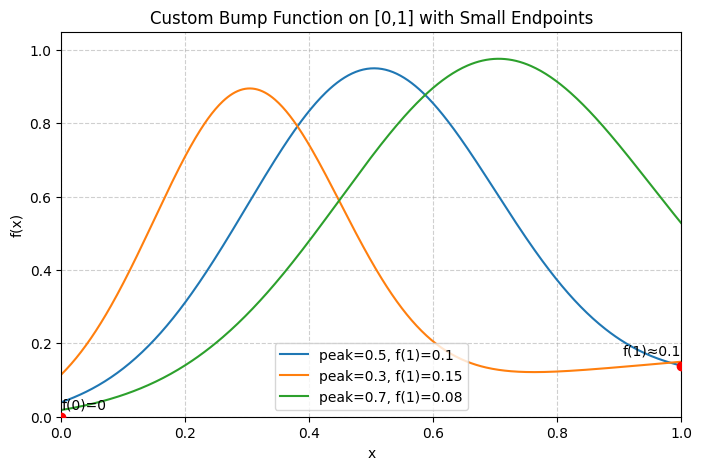

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def bump_function(x, peak_x=0.5, end_value=0.1, sigma=0.2):
    """
    自定义隆起函数，满足：
    - f(0) = 0
    - f(1) ≈ end_value（较小正值）
    - 在 x = peak_x 处取得最大值（接近1）
    """
    gaussian = np.exp(- (x - peak_x)**2 / (2 * sigma**2))
    return (1 - end_value) * gaussian + end_value * x

# 生成 x 值
x = np.linspace(0, 1, 500)

# 定义几组参数进行对比
params = [
    {'peak_x': 0.5, 'end_value': 0.1, 'sigma': 0.2, 'label': 'peak=0.5, f(1)=0.1'},
    {'peak_x': 0.3, 'end_value': 0.15, 'sigma': 0.15, 'label': 'peak=0.3, f(1)=0.15'},
    {'peak_x': 0.7, 'end_value': 0.08, 'sigma': 0.25, 'label': 'peak=0.7, f(1)=0.08'}
]

# 绘图
plt.figure(figsize=(8, 5))
for p in params:
    y = bump_function(x, peak_x=p['peak_x'], end_value=p['end_value'], sigma=p['sigma'])
    # 可选：将值域严格限制在 [0,1]
    y = np.clip(y, 0, 1)
    plt.plot(x, y, label=p['label'])

# 标注端点
plt.scatter([0, 1], [0, bump_function(np.array([1.0]), **{k:v for k,v in params[0].items() if k!='label'})[0]], 
            color='red', zorder=5)
plt.text(0, 0.02, 'f(0)=0', ha='left')
plt.text(1, bump_function(np.array([1.0]), **{k:v for k,v in params[0].items() if k!='label'})[0] + 0.03, 
         f'f(1)≈{params[0]["end_value"]}', ha='right')

plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Custom Bump Function on [0,1] with Small Endpoints')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


函数1 验证：
f(0) = 0.0000（应接近0）
f(x0=0.4) = 1.0000（应接近1）
f(1) = 0.1500（应接近0.15）
值域范围：[0.0000, 1.0005]（应在[0,1]内）

函数2 验证：
f(0) = 0.0000（应接近0）
f(x0=0.6) = 1.0000（应接近1）
f(1) = 0.3000（应接近0.3）
值域范围：[0.0000, 1.0005]（应在[0,1]内）


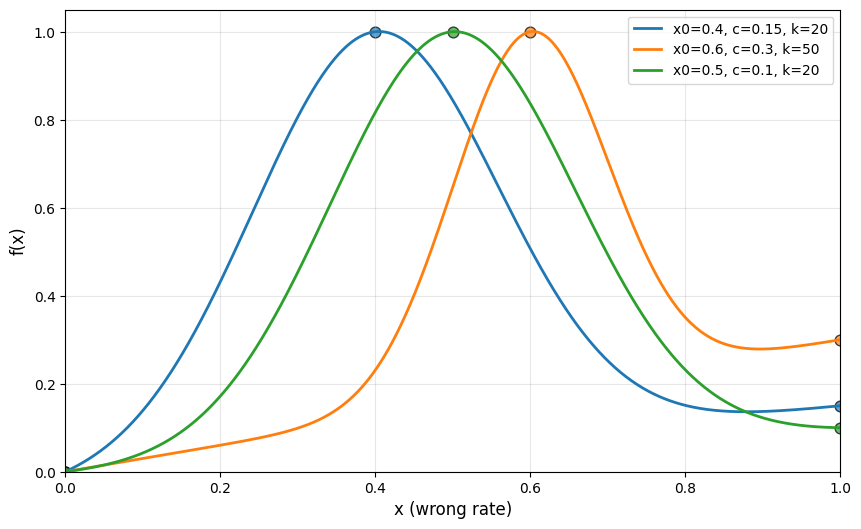

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

class ModifiedGaussian:
    def __init__(self, x0=0.5, c=0.2, k=20):
        """
        初始化修正型高斯函数（满足特定端点约束的单峰函数）
        :param x0: 最大值位置（0 < x0 < 1）
        :param c: x=1 时的函数值（0 < c < 1，小正数）
        :param k: 曲线陡峭程度（k > 0，越大曲线越尖）
        """
        assert 0 < x0 < 1, "最大值位置 x0 必须在 (0,1) 之间"
        assert 0 < c < 1, "x=1 处函数值 c 必须在 (0,1) 之间"
        assert k > 0, "陡峭系数 k 必须为正数"
        
        self.x0 = x0  # 最大值位置
        self.c = c    # x=1 处的函数值
        self.k = k    # 控制曲线陡峭程度
        
        # 求解参数 A, b, d 满足约束条件
        self.A, self.b, self.d = self._solve_parameters()
        
    def _solve_parameters(self):
        """通过约束条件求解高斯函数的参数 A, b, d"""
        # 约束方程：
        # 1. f(0) = 0 → A*exp(-k*x0²) + d = 0
        # 2. f(x0) = 1 → A + b*x0 + d = 1
        # 3. f(1) = c → A*exp(-k*(1-x0)²) + b + d = c
        
        def equations(vars):
            A, b, d = vars
            eq1 = A * np.exp(-self.k * self.x0**2) + d  # 等于0
            eq2 = A + b * self.x0 + d - 1               # 等于0
            eq3 = A * np.exp(-self.k * (1 - self.x0)**2) + b + d - self.c  # 等于0
            return [eq1, eq2, eq3]
        
        # 初始猜测值，求解方程组
        A_init, b_init, d_init = 1.0, 0.0, -0.5
        A, b, d = fsolve(equations, [A_init, b_init, d_init])
        return A, b, d
    
    def __call__(self, x):
        """计算函数值（支持单个数值或数组）"""
        x = np.asarray(x)
        # 修正型高斯函数表达式
        gaussian_term = self.A * np.exp(-self.k * (x - self.x0)** 2)
        linear_term = self.b * x + self.d
        f_x = gaussian_term + linear_term
        # 确保值域严格在 [0,1] 内（修正数值误差）
        # return np.clip(f_x, 0.0, 1.0)
        return f_x


# -------------------------- 可视化与验证 --------------------------
if __name__ == "__main__":
    # 1. 定义不同参数的函数（展示灵活性）
    func1 = ModifiedGaussian(x0=0.4, c=0.15, k=20)  # 峰值在0.4，x=1处值0.15
    func2 = ModifiedGaussian(x0=0.6, c=0.3, k=50)   # 峰值在0.6，x=1处值0.3，曲线更尖
    func3 = ModifiedGaussian(x0=0.5, c=0.1, k=20)   # 峰值在0.5，x=1处值0.1，曲线平缓
    # func3 = ModifiedGaussian(x0=0.6, c=0.1, k=20)   # 峰值在0.5，x=1处值0.1，曲线平缓

    # 2. 生成x数据（[0,1]区间均匀采样）
    x = np.linspace(0, 1, 1000)

    # 3. 计算函数值
    y1 = func1(x)
    y2 = func2(x)
    y3 = func3(x)

    # 4. 验证关键约束条件
    def print_verification(func, name):
        print(f"\n{name} 验证：")
        print(f"f(0) = {func(0):.4f}（应接近0）")
        print(f"f(x0={func.x0}) = {func(func.x0):.4f}（应接近1）")
        print(f"f(1) = {func(1):.4f}（应接近{func.c}）")
        print(f"值域范围：[{np.min(func(x)):.4f}, {np.max(func(x)):.4f}]（应在[0,1]内）")

    print_verification(func1, "函数1")
    print_verification(func2, "函数2")

    # 5. 绘图
    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, label=f"x0={func1.x0}, c={func1.c}, k={func1.k}", linewidth=2)
    plt.plot(x, y2, label=f"x0={func2.x0}, c={func2.c}, k={func2.k}", linewidth=2)
    plt.plot(x, y3, label=f"x0={func3.x0}, c={func3.c}, k={func3.k}", linewidth=2)

    # 标记关键节点（0, x0, 1）
    for func in [func1, func2, func3]:
        plt.scatter([0, func.x0, 1], [func(0), func(func.x0), func(1)], 
                    s=60, alpha=0.7, edgecolors='black')

    # 美化图表
    plt.xlabel("x (wrong rate)", fontsize=12)
    plt.ylabel("f(x)", fontsize=12)
    # plt.title("修正型高斯函数（两端小，中间有自定义峰值）", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)  # 稍大于1，方便观察峰值
    plt.show()

In [14]:

def wrong_rate2sample_probs(xs: list):
    """
    将错误率列表转换为采样概率分布
    :param xs: 错误率列表（元素范围应在[0,1]，对应定义域）
    :return: 与输入xs同长度的概率列表（值为0的位置保持0，其余归一化和为1）
    """
    # 初始化修正型高斯函数（x0=0.5，x=1处值0.1，陡峭系数20）
    func = ModifiedGaussian(x0=0.5, c=0.1, k=20)
    
    # 计算每个x对应的函数值（映射到[0,1]）
    fxs = [func(x) for x in xs]
    
    # 过滤掉值为0的元素（考虑浮点数精度，用1e-9作为阈值）
    non_zero_mask = [fx > 1e-9 for fx in fxs]
    non_zero_values = [fxs[i] for i in range(len(fxs)) if non_zero_mask[i]]
    
    # 若所有元素均为0，返回全0列表（避免除以0）
    if not non_zero_values:
        return [0.0] * len(fxs)
    
    # 对非零元素归一化（使其和为1）
    total = sum(non_zero_values)
    normalized = [fx / total if mask else 0.0 for fx, mask in zip(fxs, non_zero_mask)]
    
    return normalized

xs = [0.1, 0.5, 1, 0]
res = wrong_rate2sample_probs(xs)
print(res)

[0.03723478075298786, 0.8752411084063746, 0.08752411084063746, 0.0]


In [2]:
import numpy as np

class ModifiedGaussian:
    """修正型高斯函数（支持向量化计算）"""
    def __init__(self, x0=0.5, c=0.2, k=20):
        assert 0 < x0 < 1 and 0 < c < 1 and k > 0
        self.x0 = x0
        self.c = c
        self.k = k
        self.A, self.b, self.d = self._solve_parameters()
    
    def _solve_parameters(self):
        from scipy.optimize import fsolve
        def equations(vars):
            A, b, d = vars
            eq1 = A * np.exp(-self.k * self.x0**2) + d
            eq2 = A + b * self.x0 + d - 1
            eq3 = A * np.exp(-self.k * (1 - self.x0)**2) + b + d - self.c
            return [eq1, eq2, eq3]
        return fsolve(equations, [1.0, 0.0, -0.5])
    
    def __call__(self, x):
        """支持numpy数组的向量化计算，避免循环"""
        x = np.asarray(x)  # 确保输入为numpy数组
        gaussian_term = self.A * np.exp(-self.k * (x - self.x0)** 2)
        linear_term = self.b * x + self.d
        f_x = gaussian_term + linear_term
        return np.clip(f_x, 0.0, 1.0)  # 向量化截断


def wrong_rate2sample_probs(xs: np.ndarray) -> np.ndarray:
    """
    将错误率numpy数组转换为采样概率分布（并行化计算）
    :param xs: 错误率numpy数组（元素范围[0,1]）
    :return: 与输入同形状的概率数组（非零元素和为1）
    """
    # 输入验证：确保是numpy数组
    if not isinstance(xs, np.ndarray):
        raise TypeError("输入必须是numpy.ndarray格式")
    if xs.ndim != 1:
        raise ValueError("输入必须是一维numpy数组")
    
    # 初始化修正型高斯函数（参数可按需调整）
    func = ModifiedGaussian(x0=0.5, c=0.1, k=20)
    
    # 向量化计算所有x的函数值（无循环，并行效率高）
    fxs = func(xs)  # 直接传入数组，内部用向量化操作
    
    # 过滤非零元素（用向量化掩码，替代列表推导）
    non_zero_mask = fxs > 1e-9  # 布尔数组，形状与xs一致
    non_zero_values = fxs[non_zero_mask]  # 提取非零值
    
    # 处理全零情况
    if non_zero_values.size == 0:
        return np.zeros_like(xs, dtype=np.float64)
    
    # 向量化归一化（避免循环，直接用掩码赋值）
    total = non_zero_values.sum()
    normalized = np.zeros_like(fxs, dtype=np.float64)
    normalized[non_zero_mask] = non_zero_values / total  # 仅对非零位置赋值
    
    return normalized


# -------------------------- 测试示例 --------------------------
if __name__ == "__main__":
    # 生成测试用的错误率numpy数组（10000个元素，模拟大规模数据）
    test_xs = np.linspace(0, 1, 10, dtype=np.float64)
    
    # 计算采样概率（并行化处理）
    probs = wrong_rate2sample_probs(test_xs)
    
    # 验证结果
    print(f"输入形状: {test_xs.shape}")
    print(f"输出形状: {probs.shape}")
    print(f"非零概率和: {probs.sum():.6f}")  # 应接近1.0
    print(f"前5个概率值: {probs[:5].round(6)}")  # x=0附近应为0
    print(f"峰值附近概率: {probs[np.argmax(probs)].round(6)}")  # 峰值处概率最高

输入形状: (10,)
输出形状: (10,)
非零概率和: 1.000000
前5个概率值: [0.       0.013293 0.057244 0.149674 0.243677]
峰值附近概率: 0.246566


In [4]:
import numpy as np
import torch
from tensordict import TensorDict
from verl import DataProto

# 1. 构造 batch（TensorDict，可以为空）
# 这里我们只放一个 dummy 张量，实际保存 JSONL 时会忽略它
dummy_tensor = torch.randn(3, 10)  # 3 个样本，每个 10 维
batch_td = TensorDict({"dummy": dummy_tensor}, batch_size=[3])

# 2. 构造 non_tensor_batch（必须是 np.ndarray，dtype=object 或基本类型）
non_tensor = {
    "uid": np.array(["uid_0", "uid_1", "uid_2"], dtype=object),
    "raw_prompt": np.array(["What is 2+2?", "Explain gravity.", "Compute 5!"], dtype=object),
    "reference_answer": np.array(["4", "Gravity is...", "120"], dtype=object),
    "data_source": np.array(["math", "physics", "math"], dtype=object),
    "reward": np.array([1.0, 0.0, 1.0], dtype=np.float32),  # 可序列化为 float
    "is_hard": np.array([False, True, False], dtype=bool),  # 可序列化为 bool
}

# 3. 创建 DataProto
test_dataproto = DataProto(
    batch=batch_td,
    non_tensor_batch=non_tensor,
    meta_info={"step": 100}
)

# 4. 验证长度
print(f"DataProto length: {len(test_dataproto)}")  # 应为 3

import json
import os
# 5. 调用你定义的保存函数
def save_dataproto_to_jsonl(dataproto: DataProto, filepath: str):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    n_samples = len(dataproto)
    if n_samples == 0:
        print(f"[Warning] DataProto is empty.")
        return
    keys = list(dataproto.non_tensor_batch.keys())
    with open(filepath, "w", encoding="utf-8") as f:
        for i in range(n_samples):
            sample = {}
            for key in keys:
                val = dataproto.non_tensor_batch[key][i]
                if isinstance(val, np.ndarray):
                    continue  # skip nested arrays
                elif isinstance(val, np.generic):
                    val = val.item()
                elif isinstance(val, (str, int, float, bool)) or val is None:
                    pass
                else:
                    continue
                sample[key] = val
            f.write(json.dumps(sample, ensure_ascii=False) + "\n")
    print(f"Saved {n_samples} samples to {filepath}")

# 6. 保存到文件
save_dataproto_to_jsonl(test_dataproto, "/sharedata/zhangzitian/test/test_output.jsonl")

DataProto length: 3
Saved 3 samples to /sharedata/zhangzitian/test/test_output.jsonl


In [8]:
from tenacity import retry, stop_after_attempt, before_sleep_log
import logging

logging.basicConfig(level=logging.INFO)

@retry(
    stop=stop_after_attempt(7),
    before_sleep=before_sleep_log(logging.getLogger(), logging.INFO)
)
def stop_after_7_attempts():
    raise ValueError("something wrong")

stop_after_7_attempts()

INFO:root:Retrying __main__.stop_after_7_attempts in 0.0 seconds as it raised ValueError: something wrong.
INFO:root:Retrying __main__.stop_after_7_attempts in 0.0 seconds as it raised ValueError: something wrong.
INFO:root:Retrying __main__.stop_after_7_attempts in 0.0 seconds as it raised ValueError: something wrong.
INFO:root:Retrying __main__.stop_after_7_attempts in 0.0 seconds as it raised ValueError: something wrong.
INFO:root:Retrying __main__.stop_after_7_attempts in 0.0 seconds as it raised ValueError: something wrong.
INFO:root:Retrying __main__.stop_after_7_attempts in 0.0 seconds as it raised ValueError: something wrong.


RetryError: RetryError[<Future at 0x7fe3892f45e0 state=finished raised ValueError>]

In [13]:
from tenacity import retry, stop_after_attempt, RetryError

@retry(stop=stop_after_attempt(7))
def stop_after_7_attempts():
    raise ValueError("something wrong")

if __name__ == "__main__":
    try:
        stop_after_7_attempts()
    except RetryError as e:
        # 获取最后一次尝试中抛出的原始异常
        original_exception = e.last_attempt.exception()
        print(f"❌ API call failed after retrying: {e}. The original exception is: {original_exception}")
        print(f"{e}. fail: {original_exception}")
    except Exception as e:
        # 兜底（理论上不会走到这里）
        print(f"Unexpected error: {e}")

❌ API call failed after retrying: RetryError[<Future at 0x7fe389322980 state=finished raised ValueError>]. The original exception is: something wrong
RetryError[<Future at 0x7fe389322980 state=finished raised ValueError>]. fail: something wrong


In [41]:
import json
def _parse_json(text: str):
    """安全解析 JSON，容忍 Markdown 代码块"""
    try:
        # 移除 ```json ... ``` 包裹
        if text.startswith("```json"):
            text = text.split("```json")[1].split("```")[0].strip()
        return json.loads(text, strict=False) # text 中可能包含 \n, \r, tab键等特殊字符，导致json解析失败，添加strict=False可避免
    except (json.JSONDecodeError, IndexError) as e:
        print(e)
        return None

import json
import re

# def _parse_json(text: str):
#     """安全解析 JSON，容忍 Markdown 代码块和常见 LLM 生成错误"""
#     try:
#         # 移除 ```json ... ``` 包裹
#         if text.strip().startswith("```json"):
#             text = text.split("```json", 1)[1].split("```", 1)[0].strip()
        
#         # 修复常见非法转义：
#         # 1. 将 \$ 替换为 $（最常见问题）
#         # text = text.replace(r'\$', '$')
#         text = re.sub(r'\+\$', "$", text)
#         print(text)
        
#         # 2. 可选：修复其他非法 \x 转义（保留合法的如 \n, \t, \\, \"）
#         # 使用正则替换非法转义为 \\x（转为字面反斜杠 + x）
#         def fix_illegal_escapes(match):
#             escape_seq = match.group(0)
#             char = escape_seq[1]
#             # 合法转义字符：", \, /, b, f, n, r, t, u
#             if char in '"\\/bfnrtu':
#                 return escape_seq
#             else:
#                 # 非法转义，如 \$, \k → 转为 \\$ 或 \\k
#                 return '\\' + escape_seq
        
#         # 匹配所有 \x 形式（非 Unicode）
#         # text = re.sub(r'\\([^"\\/bfnrtu])', r'\\\1', text)
#         # 注意：上面可能不够完美，但能处理 \$

#         return json.loads(text)
#     except (json.JSONDecodeError, IndexError) as e:
#         print(f"JSON parse error: {e}")
#         return None

import json
import re

def _parse_json(text: str):
    """安全解析 JSON，容忍 Markdown 代码块和 LLM 生成的非法转义"""
    try:
        # 移除 ```json ... ``` 包裹
        if text.strip().startswith("```json"):
            text = text.split("```json", 1)[1].split("```", 1)[0].strip()
        
        # 修复所有非法 JSON 转义序列：将 \x（x 非法）转为 \\x
        # 合法转义字符：", \, /, b, f, n, r, t, u
        def _replace_illegal_escape(match):
            char = match.group(1)
            print(f"catch: {char}, replace to: \\\\{char}")
            return f"\\\\{char}"  # 两个反斜杠 + 原字符
        
        # def fix_invalid_backslashes(s):
        #         # 匹配反斜杠后面不是 "、/、b、f、n、r、t、u 的情况
        #         return re.sub(r'\\(?!["\\/bfnrtu])', r'\\\\', s)

        # 修复非法转义：
        # 只修复 \ 后不是 ["\\/bfnrtu] 且不是另一个 \ 的情况
        # def fix_invalid_backslashes(s):
        #     # 用 lookahead 判断反斜杠后面不是合法转义符
        #     return re.sub(r'\\(?!["\\/bfnrtu\\])', r'\\\\', s)

        def fix_invalid_backslashes(s: str) -> str:
            """
            修复非法 JSON 转义字符：
            - 仅当 \ 后不是合法 JSON 转义字符时修复；
            - 若该反斜杠前已有偶数个反斜杠（已被正确转义）则不修复；
            - 仅在奇数个反斜杠结尾时修复为双反斜杠。
            """

            def repl(match):
                prefix = match.group(1)
                bad_char = match.group(2)
                # 计算反斜杠数量
                backslash_count = len(prefix)
                # 如果是偶数个反斜杠，说明上一个反斜杠已经被转义，不修复
                if backslash_count % 2 == 0:
                    return prefix + bad_char
                # 如果是奇数个反斜杠，说明这是非法转义 -> 加倍
                return prefix + "\\" + bad_char

            # 匹配：连续反斜杠 + 一个非合法转义字符
            pattern = r'(\\+)(?!["\\/bfnrtu])(.?)'
            return re.sub(pattern, repl, s)
        
        # # 匹配 \ 后跟一个非法转义字符
        # print(f"before:\n{text}")
        # text = re.sub(r'\\([^"\\/bfnrtu\[\]])', _replace_illegal_escape, text)
        new_text = fix_invalid_backslashes(text)
        # print(new_text == text)
        # text = text.replace("\\", "\\\\")
        # text = text.replace("\\\\", "\\")
        # print(f"after:\n{text}")
        print(new_text[836:])

        return json.loads(new_text)
    except (json.JSONDecodeError, IndexError) as e:
        print(f"JSON parse error: {e}")
        return None
    

test = "```json\n{\n  \"new_question\": \"An independent filmmaker spends \\$50,000 to produce a short documentary. She receives a 25% grant from a cultural foundation that covers part of her production costs. After the film wins an award at a festival, a streaming platform purchases the distribution rights for \\$120,000. However, she must pay her co-producer a 10% share of the total sale revenue as per their contract. What is the filmmaker's net profit from this project?\",\n  \"solution\": \"We follow the same mathematical structure as the original problem: subtract a discounted cost from a revenue that is reduced by a percentage.\\n\\n1. **Calculate the effective production cost after the grant:**\\n   The grant covers 25% of the \\$50,000 cost, so she pays only 75%:\\n   \\\\[\\n   \\\\text{Net cost} = 50{,}000 \\\\times (1 - 0.25) = 50{,}000 \\\\times 0.75 = 37{,}500\\n   \\\\]\\n\\n2. **Calculate the net revenue after paying the co-producer:**\\n   She keeps 90% of the \\$120,000 sale:\\n   \\\\[\\n   \\\\text{Net revenue} = 120{,}000 \\\\times (1 - 0.10) = 120{,}000 \\\\times 0.90 = 108{,}000\\n   \\\\]\\n\\n3. **Compute net profit:**\\n   \\\\[\\n   \\\\text{Net profit} = \\\\text{Net revenue} - \\\\text{Net cost} = 108{,}000 - 37{,}500 = 70{,}500\\n   \\\\]\\n\\nThus, the filmmaker's net profit is \\\\boxed{70500}.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: (1) an initial expense reduced by a percentage discount/grant, (2) a gross income reduced by a percentage fee/share, and (3) net profit computed as reduced income minus reduced cost. This mirrors the original's logic: cost after 20% discount, prize after keeping 90%, and profit = net prize − net cost. The scenario differs significantly from both the original (racecar repair) and the historical enhancement (pharmaceutical vaccine development); here, the context is independent filmmaking—covering production grants, festival awards, and streaming rights—ensuring a distinct real-world domain while maintaining identical quantitative reasoning.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A robotics club is assembling beginner kits for 5 new members. Each kit includes: a programmable microcontroller priced at \\$28.00, a sensor module costing \\$22.00, a set of jumper wires for \\$8.00, and a small servo motor that costs twice the price of the jumper wire set. The electronics supplier provides a 25% discount on all items for educational clubs. What is the total cost for all 5 kits after the discount is applied?\",\n  \"solution\": \"First, identify the cost of each item in one kit:\\n- Microcontroller: \\\\$28.00\\n- Sensor module: \\\\$22.00\\n- Jumper wires: \\\\$8.00\\n- Servo motor: $2 \\\\times 8.00 = \\\\$16.00$\\n\\nCompute the total cost of one kit before discount:\\n\\\\[\\n28.00 + 22.00 + 8.00 + 16.00 = 74.00\\n\\\\]\\n\\nTotal cost for 5 kits before discount:\\n\\\\[\\n5 \\\\times 74.00 = 370.00\\n\\\\]\\n\\nApply the 25\\\\% discount (i.e., pay 75\\\\% of the total):\\n\\\\[\\n370.00 \\\\times (1 - 0.25) = 370.00 \\\\times 0.75 = 277.50\\n\\\\]\\n\\nThus, the total cost after discount is \\\\boxed{277.50}.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: (1) four items per unit, with one item priced as a multiple (specifically twice) of another; (2) a fixed percentage discount (25%) applied to the total; (3) multiplication by the number of recipients (3 in original, 5 here). The calculation steps—summing individual costs, scaling by quantity, then applying the discount—are identical. The scenario shifts from purchasing children's cooking gear to assembling educational robotics kits, which is entirely distinct from both the original cooking context and the historical pharmaceutical/vitamin scenario.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A musician is purchasing a professional-grade synthesizer priced at \\$2,500. The music store requires a 20% down payment and offers monthly installments of \\$130. If the musician decides to pay an extra \\$50 toward the down payment, what will be the remaining balance on the synthesizer after 4 monthly payments?\",\n  \"solution\": \"We are given:\\n- Total price of the synthesizer: \\\\$2,500\\n- Required down payment percentage: 20\\\\%\\n- Extra amount paid toward down payment: \\\\$50\\n- Monthly installment: \\\\$130\\n- Number of monthly payments made: 4\\n\\n**Step 1: Calculate the required down payment.**\\n\\\\[\\n\\\\text{Required down payment} = 20\\\\% \\\\times 2500 = 0.20 \\\\times 2500 = \\\\$500\\n\\\\]\\n\\n**Step 2: Add the extra amount to get the actual down payment.**\\n\\\\[\\n\\\\text{Actual down payment} = 500 + 50 = \\\\$550\\n\\\\]\\n\\n**Step 3: Compute the initial balance after down payment.**\\n\\\\[\\n\\\\text{Initial balance} = 2500 - 550 = \\\\$1950\\n\\\\]\\n\\n**Step 4: Calculate total amount paid in monthly installments after 4 months.**\\n\\\\[\\n\\\\text{Total monthly payments} = 4 \\\\times 130 = \\\\$520\\n\\\\]\\n\\n**Step 5: Subtract monthly payments from initial balance to get remaining balance.**\\n\\\\[\\n\\\\text{Remaining balance} = 1950 - 520 = \\\\$1430\\n\\\\]\\n\\nThus, the remaining balance is \\\\boxed{1430}.\",\n  \"explanation\": \"The new problem preserves the exact mathematical structure of the original problem: it involves computing a required percentage-based down payment, adding an extra fixed amount to that down payment, subtracting the total down payment from the item's price to get an initial balance, then subtracting a fixed number of monthly installments to find the remaining balance. The core operations—percentage calculation, addition, subtraction, and multiplication—are identical in sequence and logic.\\n\\nThe scenario is entirely different from the historical enhancement (which involved a farmer buying an irrigation system) and the original problem (buying a laptop). This new problem centers on a musician purchasing a synthesizer, representing a distinct domain (music/entertainment equipment) compared to agriculture or general consumer electronics.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A craft workshop purchases 12 sets of colored pencils, each set containing 30 pencils, at a cost of \\$10 per set. The workshop repackages 5 of these sets into art kits, each kit containing 6 pencils, and sells each kit for \\$3. The remaining pencils are sold in trios (groups of 3) for \\$2 per trio. Assuming all pencils are sold, what is the workshop's total profit in dollars?\",\n  \"solution\": \"We follow the same mathematical structure as the original problem.\\n\\n**Step 1: Compute total cost**\\n\\nThe workshop buys 12 sets at \\\\$10 each:\\n$$\\n\\\\text{Total cost} = 12 \\\\times 10 = \\\\$120\\n$$\\n\\n**Step 2: Compute revenue from repackaged kits**\\n\\nFrom 5 sets, total pencils = $5 \\\\times 30 = 150$.\\n\\nEach art kit contains 6 pencils, so number of kits:\\n$$\\n\\\\frac{150}{6} = 25 \\\\text{ kits}\\n$$\\n\\nRevenue from kits:\\n$$\\n25 \\\\times 3 = \\\\$75\\n$$\\n\\n**Step 3: Compute revenue from remaining pencils**\\n\\nRemaining sets = $12 - 5 = 7$, so remaining pencils = $7 \\\\times 30 = 210$.\\n\\nThese are sold in trios (3 pencils per group), so number of trios:\\n$$\\n\\\\frac{210}{3} = 70 \\\\text{ trios}\\n$$\\n\\nRevenue from trios:\\n$$\\n70 \\\\times 2 = \\\\$140\\n$$\\n\\n**Step 4: Total revenue**\\n$$\\n\\\\text{Total revenue} = 75 + 140 = \\\\$215\\n$$\\n\\n**Step 5: Compute profit**\\n$$\\n\\\\text{Profit} = \\\\text{Revenue} - \\\\text{Cost} = 215 - 120 = \\\\boxed{95}\\n$$\",\n  \"explanation\": \"The new problem preserves the exact mathematical structure of the original: total cost = 12 × $10; 5 units are repackaged into groups of 6 and sold at $3 each; remaining units (7 × 30) are sold in groups of 3 at $2 each. The calculation steps, ratios, and final profit computation are identical. The scenario shifts from highlighter pens sold by an individual (Sam) to colored pencils used in a craft workshop—distinct from the historical enhancement which involved a pharmaceutical company selling vitamin tablets. This ensures a completely different real-world context while maintaining the core arithmetic and profit-calculation logic.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A digital art installation is programmed to display a sequence of 6 animated segments, each running for exactly 50 minutes without any pause between them. If the installation starts at noon, how many hours will it take to complete the entire sequence?\",\n  \"solution\": \"We are given that there are 6 segments, each lasting 50 minutes, played consecutively with no breaks.\\n\\nFirst, compute the total time in minutes:\\n$$\\n6 \\\\times 50 = 300 \\\\text{ minutes}\\n$$\\n\\nNext, convert minutes to hours:\\n$$\\n\\\\frac{300}{60} = 5 \\\\text{ hours}\\n$$\\n\\nThus, the entire sequence takes $\\\\boxed{5}$ hours.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: multiplying 6 units by 50 minutes each and converting the total to hours. This mirrors the original TV-watching scenario and the historical IV infusion scenario in terms of arithmetic operations and unit conversion. However, the context is entirely different—it now involves a digital art installation displaying animated segments, which is distinct from both watching TV episodes (original) and administering medical infusions (historical enhancement).\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"一个装载能力为 1000 升的货车有两个泵，泵 A 单独泵出水需要 3 小时，泵 B 单独泵出水需要 6 小时。那么两个泵一起泵出水需要多少时间才能泵出货车中的水？\",\n  \"solution\": \"\\\\begin{enumerate}\n    \\\\item \\\\textbf{步骤 1：}首先，我们需要计算泵 A 和泵 B 单独泵出的速率。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\frac{1000}{3} \\\\text{ 升/小时} \\\\text{ (泵 A 的速率)} \\\\]\n    \\\\[ \\\\frac{1000}{6} \\\\text{ 升/小时} \\\\text{ (泵 B 的速率)} \\\\]\n    \\\\item \\\\textbf{步骤 2：}然后，我们将泵 A 和泵 B 的速率相加，以得到它们一起泵出的速率。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\left( \\\\frac{1000}{3} + \\\\frac{1000}{6} \\\\right) \\\\text{ 升/小时} \\\\]\n    \\\\[ = \\\\frac{2000}{6} \\\\text{ 升/小时} \\\\]\n    \\\\[ \\\\approx 333.33 \\\\text{ 升/小时} \\\\]\n    \\\\item \\\\textbf{步骤 3：}最后，我们使用公式 \\\\text{时间} = \\\\frac{\\\\text{容量}}{\\\\text{速率}} 来计算两个泵一起泵出水所需的时间。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\text{时间} = \\\\frac{1000}{\\\\frac{2000}{6}} \\\\]\n    \\\\[ = \\\\frac{6000}{2000} \\\\]\n    \\\\[ = 3 \\\\text{ 小时} \\\\]\n    \\\\end{enumerate}\n    \\\\boxed{3} \\\\text{ 小时}\",\n  \"explanation\": \"原始问题中涉及两个水管的注水速率与新问题中涉及两个泵的泵水速率对应。场景从水池转换为货车，注水时间转换为泵水时间，但核心数学知识点保持不变，主要涉及速率的加法和时间的计算。\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A florist is arranging flowers for a wedding. Each rose has 5 petals and each lily has 3 petals. If there are 8 roses and 6 lilies in the arrangement, how many petals are there in total?\",\n  \"solution\": \"To determine the total number of petals, we calculate the contributions from roses and lilies separately and then sum them:\\n\\n- Roses: $ 8 \\\\text{ roses} \\\\times 5 \\\\text{ petals per rose} = 40 \\\\text{ petals} $.\\n- Lilies: $ 6 \\\\text{ lilies} \\\\times 3 \\\\text{ petals per lily} = 18 \\\\text{ petals} $.\\n\\nAdding these together: $ 40 + 18 = 58 $ petals.\\n\\n$$\\n\\\\boxed{58}\",\n  \"explanation\": \"The original problem required calculating the total number of wheels from bicycles (2 wheels) and tricycles (3 wheels) ridden by 6 and 15 people, respectively. The new problem preserves the mathematical structure by using two categories (roses and lilies) with distinct petal counts (5 and 3) and quantities (8 and 6). Both problems involve multiplying counts by per-unit values and summing the results. The context was shifted to a floral arrangement to create a realistic, unrelated scenario while retaining the core arithmetic logic.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A local charity is tracking their fundraising progress for four different campaigns: Children's Education, Senior Healthcare, Urban Green Spaces, and Community Shelter Support. The total funding goals for each campaign are $120, $80, $90, and $60 respectively. - The Children's Education campaign has reached its goal and is fully funded. - The Senior Healthcare campaign had received 75% of its target before a recent donation drive added another $10. - The Urban Green Spaces campaign has received half of its funding goal. - The Community Shelter Support campaign had received 6 payments of $5 each. Calculate the total remaining amount needed to fully fund all campaigns.\",\n  \"solution\": \"To determine the remaining amount needed for each campaign:\\n\\n1. **Children's Education**: Fully funded.\\n   Remaining = \\$0.\\n\\n2. **Senior Healthcare**: Total goal = \\$80. Paid = 75% of \\$80 + \\$10:\\n   $$\n   0.75 \\\\times 80 + 10 = 60 + 10 = 70\n   $$\\n   Remaining = \\$80 - \\$70 = \\$10.\\n\\n3. **Urban Green Spaces**: Total goal = \\$90. Paid = half:\\n   $$\n   \\\\frac{1}{2} \\\\times 90 = 45\n   $$\\n   Remaining = \\$90 - \\$45 = \\$45.\\n\\n4. **Community Shelter Support**: Total goal = \\$60. Paid = 6 payments of \\$5:\\n   $$\n   6 \\\\times 5 = 30\n   $$\\n   Remaining = \\$60 - \\$30 = \\$30.\\n\\n**Total Remaining Amount**:\\n$$\n0 + 10 + 45 + 30 = 85\n$$\\n\\nThe final answer is \\$\\\\boxed{85}.\",\n  \"explanation\": \"The new problem retains the core concept of calculating remaining balances by subtracting partial payments from total amounts, similar to the original bill-payment scenario. Instead of household bills, it uses fundraising campaigns with different funding goals and partial contributions. The mathematical operations (subtracting fractions, fixed amounts, and multiples of payments) mirror those in the original problem, ensuring the same solution logic applies. The unique context (charity campaigns) and adjusted numerical values provide a fresh, realistic challenge while preserving the underlying arithmetic structure.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"一个水塔的充水系统由两个泵组成，泵A单独能够充满水塔需要8小时，泵B单独能够充满水塔需要16小时。假设水塔能够被同时由两个泵一起充满，请求出两个泵一起充满水塔所需的时间（以小时为单位）。\",\n  \"solution\": \"假设水塔的容积为 $V$。泵A单独能够充满水塔需要 $8$ 小时，泵B单独能够充满水塔需要 $16$ 小时。\\\\\n\\\\\n如果两个泵一起工作，充满水塔所需的时间可以使用下面的公式计算：\\\\\n\\\\\n\\\\frac{1}{t} = \\frac{1}{8} + \\frac{1}{16} = \\frac{1+1}{16} = \\frac{2}{16} = \\frac{1}{8}。\n\\\\\n\\\\\n\\\\\n\\\\frac{1}{t} = \\frac{1}{8} \\\\\n\\\\\n\\\\解得 t = \\boxed{8}。\n\\\\\n\\\\\n\\\\\n\",\n  \"explanation\": \"这个新问题保留了原始问题的数学本质，即两个泵的工作率之和。与历史增强问题无关联，且场景是水塔的充水系统。\"\n}\n```"

text = _parse_json(test)
print(f"final parsed question: \n{text['new_question']}")
print(f"final parsed solution: \n{text['solution']}")
# print(json.dumps(text))


JSON parse error: Invalid control character at: line 3 column 72 (char 188)


TypeError: 'NoneType' object is not subscriptable

In [37]:
import json
import re

def _parse_json(text: str, debug: bool = False):
    """
    尝试安全解析 JSON 文本。容忍 Markdown ```json``` 包裹，并自动：
      1) 修复非法的反斜杠转义（如 \$、\[ 等，但不改变已多重转义的情况）；
      2) 在字符串字面量内转义实际控制字符（换行、回车、制表符及其它 <0x20 的字符）；
    按顺序尝试：直接解析 -> 修复非法转义 -> 修复字符串内控制字符 -> 再次解析。
    返回解析后的 Python 对象或 None（并在 debug 时打印错误）。
    """

    def strip_markdown(s: str) -> str:
        s = s.strip()
        if s.startswith("```json"):
            # 只移除最外层的 ```json ... ```
            parts = s.split("```json", 1)[1].split("```", 1)
            return parts[0].strip() if parts else s
        return s

    def fix_invalid_backslashes(s: str) -> str:
        # """
        # 将那些真正非法（即 \ 后不是合法 JSON 转义且该 '\' 没有被前面反斜杠转义）的单个反斜杠 '补为' 双反斜杠。
        # 保持合法转义（\" \\ \/ \b \f \n \r \t \uXXXX）不变；已多层转义也不变。
        # """
        def repl(match):
            prefix = match.group(1)  # 连续的反斜杠
            bad_char = match.group(2)
            bs_count = len(prefix)
            # 如果 prefix 个数是偶数，说明最后一个反斜杠是被转义的（即不需要我们处理）
            # 例如: '\\$' -> prefix is '\\' (2) -> even -> 不处理
            if bs_count % 2 == 0:
                return prefix + bad_char
            # 否则是奇数，说明末尾的反斜杠“实际”起作用 -> 这是非法转义，需加倍
            # 把 ...\x 变成 ...\\x
            return prefix + "\\" + bad_char

        # 匹配连续若干反斜杠后跟随的下一个字符，该字符不是合法 JSON 转义起始字符
        # 注意使用 DOTALL 不是必须；这里只需要匹配普通字符（包括换行）
        pattern = r'(\\+)(?!["\\/bfnrtu])(.?)'
        return re.sub(pattern, repl, s)

    def escape_control_chars_in_strings(s: str) -> str:
        # """
        # 扫描 JSON 文本，把所有字符串字面量内部的实际控制字符（newline, tab, carriage）
        # 转为对应的转义序列。保留已有的转义序列不变。
        # 实现方法：状态机遍历，识别是否在字符串内部；处理转义字符 '\\'，并且对真正的控制字符替换为 \\n, \\r, \\t 或 \\u00XX。
        # """
        out = []
        i = 0
        n = len(s)
        in_string = False
        while i < n:
            ch = s[i]
            if ch == '"':
                # 判断这个 " 是否被转义（看其前面的连续反斜杠数量）
                # 如果前面有奇数个反斜杠则被转义，不作为字符串界定符
                j = i - 1
                bs = 0
                while j >= 0 and s[j] == '\\':
                    bs += 1
                    j -= 1
                if bs % 2 == 0:
                    # 未被转义 -> 切换字符串状态
                    in_string = not in_string
                out.append(ch)
                i += 1
                continue

            if not in_string:
                out.append(ch)
                i += 1
                continue

            # 在字符串内部
            if ch == '\\':
                # 保留反斜杠及其后一字符（如果存在），以免破坏合法的转义序列
                if i + 1 < n:
                    out.append(ch)
                    out.append(s[i + 1])
                    i += 2
                else:
                    out.append(ch)
                    i += 1
                continue

            # 如果是实际控制字符（ASCII < 0x20），需要转义
            code = ord(ch)
            if code == 0x0A:          # \n
                out.append('\\n')
            elif code == 0x0D:        # \r
                out.append('\\r')
            elif code == 0x09:        # \t
                out.append('\\t')
            elif code < 0x20:
                # 其它控制字符，用 unicode 转义
                out.append('\\u%04x' % code)
            else:
                out.append(ch)
            i += 1

        return ''.join(out)

    # 主流程
    text = strip_markdown(text)

    # 1) 直接尝试解析
    try:
        return json.loads(text, strict=False)
        # return json.loads(text)
    except json.JSONDecodeError as e1:
        if debug:
            print("第一次解析失败:", e1)

    # 2) 尝试修复非法转义（Invalid \escape）
    fixed1 = fix_invalid_backslashes(text)
    try:
        return json.loads(fixed1, strict=False)
        # return json.loads(fixed1)
    except json.JSONDecodeError as e2:
        if debug:
            print("修复非法转义后解析失败:", e2)

    # 3) 如果仍失败，尝试将字符串内部的控制字符转义（例如实际换行）
    fixed2 = escape_control_chars_in_strings(fixed1)
    if debug:
        print("----- 经过修复（非法转义 + 字符串控制字符）后的片段 -----")
        print(fixed2[:800])
    try:
        return json.loads(fixed2, strict=False)
        # return json.loads(fixed2)
    except json.JSONDecodeError as e3:
        if debug:
            print("最终解析仍失败:", e3)
        return None



# test = "```json\n{\n  \"new_question\": \"An independent filmmaker spends \\$50,000 to produce a short documentary. She receives a 25% grant from a cultural foundation that covers part of her production costs. After the film wins an award at a festival, a streaming platform purchases the distribution rights for \\$120,000. However, she must pay her co-producer a 10% share of the total sale revenue as per their contract. What is the filmmaker's net profit from this project?\",\n  \"solution\": \"We follow the same mathematical structure as the original problem: subtract a discounted cost from a revenue that is reduced by a percentage.\\n\\n1. **Calculate the effective production cost after the grant:**\\n   The grant covers 25% of the \\$50,000 cost, so she pays only 75%:\\n   \\\\[\\n   \\\\text{Net cost} = 50{,}000 \\\\times (1 - 0.25) = 50{,}000 \\\\times 0.75 = 37{,}500\\n   \\\\]\\n\\n2. **Calculate the net revenue after paying the co-producer:**\\n   She keeps 90% of the \\$120,000 sale:\\n   \\\\[\\n   \\\\text{Net revenue} = 120{,}000 \\\\times (1 - 0.10) = 120{,}000 \\\\times 0.90 = 108{,}000\\n   \\\\]\\n\\n3. **Compute net profit:**\\n   \\\\[\\n   \\\\text{Net profit} = \\\\text{Net revenue} - \\\\text{Net cost} = 108{,}000 - 37{,}500 = 70{,}500\\n   \\\\]\\n\\nThus, the filmmaker's net profit is \\\\boxed{70500}.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: (1) an initial expense reduced by a percentage discount/grant, (2) a gross income reduced by a percentage fee/share, and (3) net profit computed as reduced income minus reduced cost. This mirrors the original's logic: cost after 20% discount, prize after keeping 90%, and profit = net prize − net cost. The scenario differs significantly from both the original (racecar repair) and the historical enhancement (pharmaceutical vaccine development); here, the context is independent filmmaking—covering production grants, festival awards, and streaming rights—ensuring a distinct real-world domain while maintaining identical quantitative reasoning.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A robotics club is assembling beginner kits for 5 new members. Each kit includes: a programmable microcontroller priced at \\$28.00, a sensor module costing \\$22.00, a set of jumper wires for \\$8.00, and a small servo motor that costs twice the price of the jumper wire set. The electronics supplier provides a 25% discount on all items for educational clubs. What is the total cost for all 5 kits after the discount is applied?\",\n  \"solution\": \"First, identify the cost of each item in one kit:\\n- Microcontroller: \\\\$28.00\\n- Sensor module: \\\\$22.00\\n- Jumper wires: \\\\$8.00\\n- Servo motor: $2 \\\\times 8.00 = \\\\$16.00$\\n\\nCompute the total cost of one kit before discount:\\n\\\\[\\n28.00 + 22.00 + 8.00 + 16.00 = 74.00\\n\\\\]\\n\\nTotal cost for 5 kits before discount:\\n\\\\[\\n5 \\\\times 74.00 = 370.00\\n\\\\]\\n\\nApply the 25\\\\% discount (i.e., pay 75\\\\% of the total):\\n\\\\[\\n370.00 \\\\times (1 - 0.25) = 370.00 \\\\times 0.75 = 277.50\\n\\\\]\\n\\nThus, the total cost after discount is \\\\boxed{277.50}.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: (1) four items per unit, with one item priced as a multiple (specifically twice) of another; (2) a fixed percentage discount (25%) applied to the total; (3) multiplication by the number of recipients (3 in original, 5 here). The calculation steps—summing individual costs, scaling by quantity, then applying the discount—are identical. The scenario shifts from purchasing children's cooking gear to assembling educational robotics kits, which is entirely distinct from both the original cooking context and the historical pharmaceutical/vitamin scenario.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A musician is purchasing a professional-grade synthesizer priced at \\$2,500. The music store requires a 20% down payment and offers monthly installments of \\$130. If the musician decides to pay an extra \\$50 toward the down payment, what will be the remaining balance on the synthesizer after 4 monthly payments?\",\n  \"solution\": \"We are given:\\n- Total price of the synthesizer: \\\\$2,500\\n- Required down payment percentage: 20\\\\%\\n- Extra amount paid toward down payment: \\\\$50\\n- Monthly installment: \\\\$130\\n- Number of monthly payments made: 4\\n\\n**Step 1: Calculate the required down payment.**\\n\\\\[\\n\\\\text{Required down payment} = 20\\\\% \\\\times 2500 = 0.20 \\\\times 2500 = \\\\$500\\n\\\\]\\n\\n**Step 2: Add the extra amount to get the actual down payment.**\\n\\\\[\\n\\\\text{Actual down payment} = 500 + 50 = \\\\$550\\n\\\\]\\n\\n**Step 3: Compute the initial balance after down payment.**\\n\\\\[\\n\\\\text{Initial balance} = 2500 - 550 = \\\\$1950\\n\\\\]\\n\\n**Step 4: Calculate total amount paid in monthly installments after 4 months.**\\n\\\\[\\n\\\\text{Total monthly payments} = 4 \\\\times 130 = \\\\$520\\n\\\\]\\n\\n**Step 5: Subtract monthly payments from initial balance to get remaining balance.**\\n\\\\[\\n\\\\text{Remaining balance} = 1950 - 520 = \\\\$1430\\n\\\\]\\n\\nThus, the remaining balance is \\\\boxed{1430}.\",\n  \"explanation\": \"The new problem preserves the exact mathematical structure of the original problem: it involves computing a required percentage-based down payment, adding an extra fixed amount to that down payment, subtracting the total down payment from the item's price to get an initial balance, then subtracting a fixed number of monthly installments to find the remaining balance. The core operations—percentage calculation, addition, subtraction, and multiplication—are identical in sequence and logic.\\n\\nThe scenario is entirely different from the historical enhancement (which involved a farmer buying an irrigation system) and the original problem (buying a laptop). This new problem centers on a musician purchasing a synthesizer, representing a distinct domain (music/entertainment equipment) compared to agriculture or general consumer electronics.\"\n}\n```"
# # test = "```json\n{\n  \"new_question\": \"A craft workshop purchases 12 sets of colored pencils, each set containing 30 pencils, at a cost of \\$10 per set. The workshop repackages 5 of these sets into art kits, each kit containing 6 pencils, and sells each kit for \\$3. The remaining pencils are sold in trios (groups of 3) for \\$2 per trio. Assuming all pencils are sold, what is the workshop's total profit in dollars?\",\n  \"solution\": \"We follow the same mathematical structure as the original problem.\\n\\n**Step 1: Compute total cost**\\n\\nThe workshop buys 12 sets at \\\\$10 each:\\n$$\\n\\\\text{Total cost} = 12 \\\\times 10 = \\\\$120\\n$$\\n\\n**Step 2: Compute revenue from repackaged kits**\\n\\nFrom 5 sets, total pencils = $5 \\\\times 30 = 150$.\\n\\nEach art kit contains 6 pencils, so number of kits:\\n$$\\n\\\\frac{150}{6} = 25 \\\\text{ kits}\\n$$\\n\\nRevenue from kits:\\n$$\\n25 \\\\times 3 = \\\\$75\\n$$\\n\\n**Step 3: Compute revenue from remaining pencils**\\n\\nRemaining sets = $12 - 5 = 7$, so remaining pencils = $7 \\\\times 30 = 210$.\\n\\nThese are sold in trios (3 pencils per group), so number of trios:\\n$$\\n\\\\frac{210}{3} = 70 \\\\text{ trios}\\n$$\\n\\nRevenue from trios:\\n$$\\n70 \\\\times 2 = \\\\$140\\n$$\\n\\n**Step 4: Total revenue**\\n$$\\n\\\\text{Total revenue} = 75 + 140 = \\\\$215\\n$$\\n\\n**Step 5: Compute profit**\\n$$\\n\\\\text{Profit} = \\\\text{Revenue} - \\\\text{Cost} = 215 - 120 = \\\\boxed{95}\\n$$\",\n  \"explanation\": \"The new problem preserves the exact mathematical structure of the original: total cost = 12 × $10; 5 units are repackaged into groups of 6 and sold at $3 each; remaining units (7 × 30) are sold in groups of 3 at $2 each. The calculation steps, ratios, and final profit computation are identical. The scenario shifts from highlighter pens sold by an individual (Sam) to colored pencils used in a craft workshop—distinct from the historical enhancement which involved a pharmaceutical company selling vitamin tablets. This ensures a completely different real-world context while maintaining the core arithmetic and profit-calculation logic.\"\n}\n```"
# # test = "```json\n{\n  \"new_question\": \"A digital art installation is programmed to display a sequence of 6 animated segments, each running for exactly 50 minutes without any pause between them. If the installation starts at noon, how many hours will it take to complete the entire sequence?\",\n  \"solution\": \"We are given that there are 6 segments, each lasting 50 minutes, played consecutively with no breaks.\\n\\nFirst, compute the total time in minutes:\\n$$\\n6 \\\\times 50 = 300 \\\\text{ minutes}\\n$$\\n\\nNext, convert minutes to hours:\\n$$\\n\\\\frac{300}{60} = 5 \\\\text{ hours}\\n$$\\n\\nThus, the entire sequence takes $\\\\boxed{5}$ hours.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: multiplying 6 units by 50 minutes each and converting the total to hours. This mirrors the original TV-watching scenario and the historical IV infusion scenario in terms of arithmetic operations and unit conversion. However, the context is entirely different—it now involves a digital art installation displaying animated segments, which is distinct from both watching TV episodes (original) and administering medical infusions (historical enhancement).\"\n}\n```"
# # test = "```json\n{\n  \"new_question\": \"一个装载能力为 1000 升的货车有两个泵，泵 A 单独泵出水需要 3 小时，泵 B 单独泵出水需要 6 小时。那么两个泵一起泵出水需要多少时间才能泵出货车中的水？\",\n  \"solution\": \"\\\\begin{enumerate}\n    \\\\item \\\\textbf{步骤 1：}首先，我们需要计算泵 A 和泵 B 单独泵出的速率。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\frac{1000}{3} \\\\text{ 升/小时} \\\\text{ (泵 A 的速率)} \\\\]\n    \\\\[ \\\\frac{1000}{6} \\\\text{ 升/小时} \\\\text{ (泵 B 的速率)} \\\\]\n    \\\\item \\\\textbf{步骤 2：}然后，我们将泵 A 和泵 B 的速率相加，以得到它们一起泵出的速率。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\left( \\\\frac{1000}{3} + \\\\frac{1000}{6} \\\\right) \\\\text{ 升/小时} \\\\]\n    \\\\[ = \\\\frac{2000}{6} \\\\text{ 升/小时} \\\\]\n    \\\\[ \\\\approx 333.33 \\\\text{ 升/小时} \\\\]\n    \\\\item \\\\textbf{步骤 3：}最后，我们使用公式 \\\\text{时间} = \\\\frac{\\\\text{容量}}{\\\\text{速率}} 来计算两个泵一起泵出水所需的时间。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\text{时间} = \\\\frac{1000}{\\\\frac{2000}{6}} \\\\]\n    \\\\[ = \\\\frac{6000}{2000} \\\\]\n    \\\\[ = 3 \\\\text{ 小时} \\\\]\n    \\\\end{enumerate}\n    \\\\boxed{3} \\\\text{ 小时}\",\n  \"explanation\": \"原始问题中涉及两个水管的注水速率与新问题中涉及两个泵的泵水速率对应。场景从水池转换为货车，注水时间转换为泵水时间，但核心数学知识点保持不变，主要涉及速率的加法和时间的计算。\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"一个水塔的充水系统由两个泵组成，泵A单独能够充满水塔需要8小时，泵B单独能够充满水塔需要16小时。假设水塔能够被同时由两个泵一起充满，请求出两个泵一起充满水塔所需的时间（以小时为单位）。\",\n  \"solution\": \"假设水塔的容积为 $V$。泵A单独能够充满水塔需要 $8$ 小时，泵B单独能够充满水塔需要 $16$ 小时。\\\\\n\\\\\n如果两个泵一起工作，充满水塔所需的时间可以使用下面的公式计算：\\\\\n\\\\\n\\\\frac{1}{t} = \\frac{1}{8} + \\frac{1}{16} = \\frac{1+1}{16} = \\frac{2}{16} = \\frac{1}{8}。\n\\\\\n\\\\\n\\\\\n\\\\frac{1}{t} = \\frac{1}{8} \\\\\n\\\\\n\\\\解得 t = \\boxed{8}。\n\\\\\n\\\\\n\\\\\n\",\n  \"explanation\": \"这个新问题保留了原始问题的数学本质，即两个泵的工作率之和。与历史增强问题无关联，且场景是水塔的充水系统。\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"在一家酒庄，有两条输送葡萄酒的输酒管道，输酒管道A单独输送需要3小时，输酒管道B单独输送需要6小时。那么两条输酒管道同时输送需要多少时间才能输送满酒罐车？\",\n  \"solution\": \"设酒罐车的容量为 $C$，输酒管道A的速率为 $\\frac{C}{3}$，输酒管道B的速率为 $\\frac{C}{6}$。两个输酒管道同时输送的速率为 $\\frac{C}{3} + \\frac{C}{6} = \\frac{C}{2}$。因此，两条输酒管道同时输送需要的时间为 $\\frac{C}{\\frac{C}{2}} = 2$ 小时。\\\\\n\\boxed{2} \",\n  \"explanation\": \"原始问题涉及两个水管的注水速率和时间关系，场景迁移依据是将水池注水的概念转化为输送葡萄酒的输酒管道输送酒罐车的场景。水管A和水管B的速率关系保持不变，水管A需要3小时，水管B需要6小时。因此，场景迁移依据是保持速率关系不变，同时将输送水池转化为输送酒罐车的场景。\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"一个车间有两个泵水机，泵水机A单独泵水需要4小时，泵水机B单独泵水需要8小时。那么两个泵水机一起泵水需要多少时间才能泵满水塔？\",\n  \"solution\": \"\\\\begin{align*}\n\\\\text{两泵水机的泵水速率之和}&amp;=\\\\frac{1}{4}+\\\\frac{1}{8}=\\frac{3}{8}\\\\text{m}^3/\\\\text{h}\\\\\\\\\n\\\\text{因此，两泵水机一起泵水需要}\\\\boxed{2.67}\\\\text{小时才能泵满水塔。}\n\\\\end{align*}\",\n  \"explanation\": \"原始问题涉及水池的注水问题，历史增强问题处在税务的场景中。新问题保留了原始问题的数学本质，改变了场景为车间的泵水问题。\"\n}\n```"


# test = "```json\n{\n  \"new_question\": \"An independent filmmaker spends \\$50,000 to produce a short documentary. She receives a 25% grant from a cultural foundation that covers part of her production costs. After the film wins an award at a festival, a streaming platform purchases the distribution rights for \\$120,000. However, she must pay her co-producer a 10% share of the total sale revenue as per their contract. What is the filmmaker's net profit from this project?\",\n  \"solution\": \"We follow the same mathematical structure as the original problem: subtract a discounted cost from a revenue that is reduced by a percentage.\\n\\n1. **Calculate the effective production cost after the grant:**\\n   The grant covers 25% of the \\$50,000 cost, so she pays only 75%:\\n   \\\\[\\n   \\\\text{Net cost} = 50{,}000 \\\\times (1 - 0.25) = 50{,}000 \\\\times 0.75 = 37{,}500\\n   \\\\]\\n\\n2. **Calculate the net revenue after paying the co-producer:**\\n   She keeps 90% of the \\$120,000 sale:\\n   \\\\[\\n   \\\\text{Net revenue} = 120{,}000 \\\\times (1 - 0.10) = 120{,}000 \\\\times 0.90 = 108{,}000\\n   \\\\]\\n\\n3. **Compute net profit:**\\n   \\\\[\\n   \\\\text{Net profit} = \\\\text{Net revenue} - \\\\text{Net cost} = 108{,}000 - 37{,}500 = 70{,}500\\n   \\\\]\\n\\nThus, the filmmaker's net profit is \\\\boxed{70500}.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: (1) an initial expense reduced by a percentage discount/grant, (2) a gross income reduced by a percentage fee/share, and (3) net profit computed as reduced income minus reduced cost. This mirrors the original's logic: cost after 20% discount, prize after keeping 90%, and profit = net prize − net cost. The scenario differs significantly from both the original (racecar repair) and the historical enhancement (pharmaceutical vaccine development); here, the context is independent filmmaking—covering production grants, festival awards, and streaming rights—ensuring a distinct real-world domain while maintaining identical quantitative reasoning.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A robotics club is assembling beginner kits for 5 new members. Each kit includes: a programmable microcontroller priced at \\$28.00, a sensor module costing \\$22.00, a set of jumper wires for \\$8.00, and a small servo motor that costs twice the price of the jumper wire set. The electronics supplier provides a 25% discount on all items for educational clubs. What is the total cost for all 5 kits after the discount is applied?\",\n  \"solution\": \"First, identify the cost of each item in one kit:\\n- Microcontroller: \\\\$28.00\\n- Sensor module: \\\\$22.00\\n- Jumper wires: \\\\$8.00\\n- Servo motor: $2 \\\\times 8.00 = \\\\$16.00$\\n\\nCompute the total cost of one kit before discount:\\n\\\\[\\n28.00 + 22.00 + 8.00 + 16.00 = 74.00\\n\\\\]\\n\\nTotal cost for 5 kits before discount:\\n\\\\[\\n5 \\\\times 74.00 = 370.00\\n\\\\]\\n\\nApply the 25\\\\% discount (i.e., pay 75\\\\% of the total):\\n\\\\[\\n370.00 \\\\times (1 - 0.25) = 370.00 \\\\times 0.75 = 277.50\\n\\\\]\\n\\nThus, the total cost after discount is \\\\boxed{277.50}.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: (1) four items per unit, with one item priced as a multiple (specifically twice) of another; (2) a fixed percentage discount (25%) applied to the total; (3) multiplication by the number of recipients (3 in original, 5 here). The calculation steps—summing individual costs, scaling by quantity, then applying the discount—are identical. The scenario shifts from purchasing children's cooking gear to assembling educational robotics kits, which is entirely distinct from both the original cooking context and the historical pharmaceutical/vitamin scenario.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A musician is purchasing a professional-grade synthesizer priced at \\$2,500. The music store requires a 20% down payment and offers monthly installments of \\$130. If the musician decides to pay an extra \\$50 toward the down payment, what will be the remaining balance on the synthesizer after 4 monthly payments?\",\n  \"solution\": \"We are given:\\n- Total price of the synthesizer: \\\\$2,500\\n- Required down payment percentage: 20\\\\%\\n- Extra amount paid toward down payment: \\\\$50\\n- Monthly installment: \\\\$130\\n- Number of monthly payments made: 4\\n\\n**Step 1: Calculate the required down payment.**\\n\\\\[\\n\\\\text{Required down payment} = 20\\\\% \\\\times 2500 = 0.20 \\\\times 2500 = \\\\$500\\n\\\\]\\n\\n**Step 2: Add the extra amount to get the actual down payment.**\\n\\\\[\\n\\\\text{Actual down payment} = 500 + 50 = \\\\$550\\n\\\\]\\n\\n**Step 3: Compute the initial balance after down payment.**\\n\\\\[\\n\\\\text{Initial balance} = 2500 - 550 = \\\\$1950\\n\\\\]\\n\\n**Step 4: Calculate total amount paid in monthly installments after 4 months.**\\n\\\\[\\n\\\\text{Total monthly payments} = 4 \\\\times 130 = \\\\$520\\n\\\\]\\n\\n**Step 5: Subtract monthly payments from initial balance to get remaining balance.**\\n\\\\[\\n\\\\text{Remaining balance} = 1950 - 520 = \\\\$1430\\n\\\\]\\n\\nThus, the remaining balance is \\\\boxed{1430}.\",\n  \"explanation\": \"The new problem preserves the exact mathematical structure of the original problem: it involves computing a required percentage-based down payment, adding an extra fixed amount to that down payment, subtracting the total down payment from the item's price to get an initial balance, then subtracting a fixed number of monthly installments to find the remaining balance. The core operations—percentage calculation, addition, subtraction, and multiplication—are identical in sequence and logic.\\n\\nThe scenario is entirely different from the historical enhancement (which involved a farmer buying an irrigation system) and the original problem (buying a laptop). This new problem centers on a musician purchasing a synthesizer, representing a distinct domain (music/entertainment equipment) compared to agriculture or general consumer electronics.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A craft workshop purchases 12 sets of colored pencils, each set containing 30 pencils, at a cost of \\$10 per set. The workshop repackages 5 of these sets into art kits, each kit containing 6 pencils, and sells each kit for \\$3. The remaining pencils are sold in trios (groups of 3) for \\$2 per trio. Assuming all pencils are sold, what is the workshop's total profit in dollars?\",\n  \"solution\": \"We follow the same mathematical structure as the original problem.\\n\\n**Step 1: Compute total cost**\\n\\nThe workshop buys 12 sets at \\\\$10 each:\\n$$\\n\\\\text{Total cost} = 12 \\\\times 10 = \\\\$120\\n$$\\n\\n**Step 2: Compute revenue from repackaged kits**\\n\\nFrom 5 sets, total pencils = $5 \\\\times 30 = 150$.\\n\\nEach art kit contains 6 pencils, so number of kits:\\n$$\\n\\\\frac{150}{6} = 25 \\\\text{ kits}\\n$$\\n\\nRevenue from kits:\\n$$\\n25 \\\\times 3 = \\\\$75\\n$$\\n\\n**Step 3: Compute revenue from remaining pencils**\\n\\nRemaining sets = $12 - 5 = 7$, so remaining pencils = $7 \\\\times 30 = 210$.\\n\\nThese are sold in trios (3 pencils per group), so number of trios:\\n$$\\n\\\\frac{210}{3} = 70 \\\\text{ trios}\\n$$\\n\\nRevenue from trios:\\n$$\\n70 \\\\times 2 = \\\\$140\\n$$\\n\\n**Step 4: Total revenue**\\n$$\\n\\\\text{Total revenue} = 75 + 140 = \\\\$215\\n$$\\n\\n**Step 5: Compute profit**\\n$$\\n\\\\text{Profit} = \\\\text{Revenue} - \\\\text{Cost} = 215 - 120 = \\\\boxed{95}\\n$$\",\n  \"explanation\": \"The new problem preserves the exact mathematical structure of the original: total cost = 12 × $10; 5 units are repackaged into groups of 6 and sold at $3 each; remaining units (7 × 30) are sold in groups of 3 at $2 each. The calculation steps, ratios, and final profit computation are identical. The scenario shifts from highlighter pens sold by an individual (Sam) to colored pencils used in a craft workshop—distinct from the historical enhancement which involved a pharmaceutical company selling vitamin tablets. This ensures a completely different real-world context while maintaining the core arithmetic and profit-calculation logic.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A digital art installation is programmed to display a sequence of 6 animated segments, each running for exactly 50 minutes without any pause between them. If the installation starts at noon, how many hours will it take to complete the entire sequence?\",\n  \"solution\": \"We are given that there are 6 segments, each lasting 50 minutes, played consecutively with no breaks.\\n\\nFirst, compute the total time in minutes:\\n$$\\n6 \\\\times 50 = 300 \\\\text{ minutes}\\n$$\\n\\nNext, convert minutes to hours:\\n$$\\n\\\\frac{300}{60} = 5 \\\\text{ hours}\\n$$\\n\\nThus, the entire sequence takes $\\\\boxed{5}$ hours.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: multiplying 6 units by 50 minutes each and converting the total to hours. This mirrors the original TV-watching scenario and the historical IV infusion scenario in terms of arithmetic operations and unit conversion. However, the context is entirely different—it now involves a digital art installation displaying animated segments, which is distinct from both watching TV episodes (original) and administering medical infusions (historical enhancement).\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"一个装载能力为 1000 升的货车有两个泵，泵 A 单独泵出水需要 3 小时，泵 B 单独泵出水需要 6 小时。那么两个泵一起泵出水需要多少时间才能泵出货车中的水？\",\n  \"solution\": \"\\\\begin{enumerate}\n    \\\\item \\\\textbf{步骤 1：}首先，我们需要计算泵 A 和泵 B 单独泵出的速率。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\frac{1000}{3} \\\\text{ 升/小时} \\\\text{ (泵 A 的速率)} \\\\]\n    \\\\[ \\\\frac{1000}{6} \\\\text{ 升/小时} \\\\text{ (泵 B 的速率)} \\\\]\n    \\\\item \\\\textbf{步骤 2：}然后，我们将泵 A 和泵 B 的速率相加，以得到它们一起泵出的速率。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\left( \\\\frac{1000}{3} + \\\\frac{1000}{6} \\\\right) \\\\text{ 升/小时} \\\\]\n    \\\\[ = \\\\frac{2000}{6} \\\\text{ 升/小时} \\\\]\n    \\\\[ \\\\approx 333.33 \\\\text{ 升/小时} \\\\]\n    \\\\item \\\\textbf{步骤 3：}最后，我们使用公式 \\\\text{时间} = \\\\frac{\\\\text{容量}}{\\\\text{速率}} 来计算两个泵一起泵出水所需的时间。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\text{时间} = \\\\frac{1000}{\\\\frac{2000}{6}} \\\\]\n    \\\\[ = \\\\frac{6000}{2000} \\\\]\n    \\\\[ = 3 \\\\text{ 小时} \\\\]\n    \\\\end{enumerate}\n    \\\\boxed{3} \\\\text{ 小时}\",\n  \"explanation\": \"原始问题中涉及两个水管的注水速率与新问题中涉及两个泵的泵水速率对应。场景从水池转换为货车，注水时间转换为泵水时间，但核心数学知识点保持不变，主要涉及速率的加法和时间的计算。\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A florist is arranging flowers for a wedding. Each rose has 5 petals and each lily has 3 petals. If there are 8 roses and 6 lilies in the arrangement, how many petals are there in total?\",\n  \"solution\": \"To determine the total number of petals, we calculate the contributions from roses and lilies separately and then sum them:\\n\\n- Roses: $ 8 \\\\text{ roses} \\\\times 5 \\\\text{ petals per rose} = 40 \\\\text{ petals} $.\\n- Lilies: $ 6 \\\\text{ lilies} \\\\times 3 \\\\text{ petals per lily} = 18 \\\\text{ petals} $.\\n\\nAdding these together: $ 40 + 18 = 58 $ petals.\\n\\n$$\\n\\\\boxed{58}\",\n  \"explanation\": \"The original problem required calculating the total number of wheels from bicycles (2 wheels) and tricycles (3 wheels) ridden by 6 and 15 people, respectively. The new problem preserves the mathematical structure by using two categories (roses and lilies) with distinct petal counts (5 and 3) and quantities (8 and 6). Both problems involve multiplying counts by per-unit values and summing the results. The context was shifted to a floral arrangement to create a realistic, unrelated scenario while retaining the core arithmetic logic.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A local charity is tracking their fundraising progress for four different campaigns: Children's Education, Senior Healthcare, Urban Green Spaces, and Community Shelter Support. The total funding goals for each campaign are $120, $80, $90, and $60 respectively. - The Children's Education campaign has reached its goal and is fully funded. - The Senior Healthcare campaign had received 75% of its target before a recent donation drive added another $10. - The Urban Green Spaces campaign has received half of its funding goal. - The Community Shelter Support campaign had received 6 payments of $5 each. Calculate the total remaining amount needed to fully fund all campaigns.\",\n  \"solution\": \"To determine the remaining amount needed for each campaign:\\n\\n1. **Children's Education**: Fully funded.\\n   Remaining = \\$0.\\n\\n2. **Senior Healthcare**: Total goal = \\$80. Paid = 75% of \\$80 + \\$10:\\n   $$\n   0.75 \\\\times 80 + 10 = 60 + 10 = 70\n   $$\\n   Remaining = \\$80 - \\$70 = \\$10.\\n\\n3. **Urban Green Spaces**: Total goal = \\$90. Paid = half:\\n   $$\n   \\\\frac{1}{2} \\\\times 90 = 45\n   $$\\n   Remaining = \\$90 - \\$45 = \\$45.\\n\\n4. **Community Shelter Support**: Total goal = \\$60. Paid = 6 payments of \\$5:\\n   $$\n   6 \\\\times 5 = 30\n   $$\\n   Remaining = \\$60 - \\$30 = \\$30.\\n\\n**Total Remaining Amount**:\\n$$\n0 + 10 + 45 + 30 = 85\n$$\\n\\nThe final answer is \\$\\\\boxed{85}.\",\n  \"explanation\": \"The new problem retains the core concept of calculating remaining balances by subtracting partial payments from total amounts, similar to the original bill-payment scenario. Instead of household bills, it uses fundraising campaigns with different funding goals and partial contributions. The mathematical operations (subtracting fractions, fixed amounts, and multiples of payments) mirror those in the original problem, ensuring the same solution logic applies. The unique context (charity campaigns) and adjusted numerical values provide a fresh, realistic challenge while preserving the underlying arithmetic structure.\"\n}\n```"


text = _parse_json(test, debug=True)
print(text)
print(f"final parsed question: \n{text['new_question']}")
print(f"final parsed solution: \n{text['solution']}")

{'new_question': '一个水塔的充水系统由两个泵组成，泵A单独能够充满水塔需要8小时，泵B单独能够充满水塔需要16小时。假设水塔能够被同时由两个泵一起充满，请求出两个泵一起充满水塔所需的时间（以小时为单位）。', 'solution': '假设水塔的容积为 $V$。泵A单独能够充满水塔需要 $8$ 小时，泵B单独能够充满水塔需要 $16$ 小时。\\\n\\\n如果两个泵一起工作，充满水塔所需的时间可以使用下面的公式计算：\\\n\\\n\\frac{1}{t} = \x0crac{1}{8} + \x0crac{1}{16} = \x0crac{1+1}{16} = \x0crac{2}{16} = \x0crac{1}{8}。\n\\\n\\\n\\\n\\frac{1}{t} = \x0crac{1}{8} \\\n\\\n\\解得 t = \x08oxed{8}。\n\\\n\\\n\\\n', 'explanation': '这个新问题保留了原始问题的数学本质，即两个泵的工作率之和。与历史增强问题无关联，且场景是水塔的充水系统。'}
final parsed question: 
一个水塔的充水系统由两个泵组成，泵A单独能够充满水塔需要8小时，泵B单独能够充满水塔需要16小时。假设水塔能够被同时由两个泵一起充满，请求出两个泵一起充满水塔所需的时间（以小时为单位）。
final parsed solution: 
假设水塔的容积为 $V$。泵A单独能够充满水塔需要 $8$ 小时，泵B单独能够充满水塔需要 $16$ 小时。\
\
如果两个泵一起工作，充满水塔所需的时间可以使用下面的公式计算：\
\
\frac{1}{t} = rac{1}{8} + rac{1}{16} = rac{1+1}{16} = rac{2}{16} = rac{1}{8}。
\
\
\
\frac{1}{t} = rac{1}{8} \
\
\解得 t =oxed{8}。
\
\
\



In [100]:
import json
import re


def _parse_json(text: str, debug: bool = False):
    """
    更鲁棒的 JSON 解析器：
    - 移除 ```json ... ``` 包裹；
    - 在字符串字面量内部：
        * 将那些会被 JSON 误解析为控制字符的单斜杠 + 多字母序列（如 \\frac）改为双斜杠 (\\\\frac)；
        * 保留合法 JSON 转义（\\n, \\t, \\\", \\\\, \\/, \\b, \\f, \\r, \\uXXXX）；
        * 如果遇到真实控制字符（换行、回车、制表和其它 < 0x20）则转义为 \\n / \\r / \\t / \\uXXXX；
    - 尽量只对“活跃”的（前面有奇数个斜杠）情况进行加倍；若前导反斜杠数为偶数（例如已经是 \\\\frac），则不改。
    """
    def _fix_missing_commas(text: str) -> str:
        # 修复 solution 和 explanation 之间缺失的逗号
        # 尝试修复常见错误：键之间缺逗号
        # pattern = re.compile(r'"}+\n\s*"(?P<key>[^"]+)":')
        # fixed = pattern.sub(r'",\n  "\g<key>":', text)
        pattern = r'}\n\s+"explanation":'
        fixed = re.sub(pattern, '}",\n  "explanation":', text)
        return fixed
    
    def strip_markdown(s: str) -> str:
        s = s.strip()
        if s.startswith("```json"):
            parts = s.split("```json", 1)[1].split("```", 1)
            return parts[0].strip() if parts else s
        return s

    # text = _fix_missing_commas(text)
    # print(f"fix: {text}")

    text = strip_markdown(text)

    # 快速尝试直接解析
    try:
        return json.loads(text)
    except json.JSONDecodeError as e:
        if debug:
            print("第一次解析失败:", e)

    # 我们将逐字符扫描，专注于字符串字面量内部做精准修复
    out_chars = []
    i = 0
    n = len(text)
    in_string = False

    while i < n:
        ch = text[i]

        # 处理双引号是否作为字符串边界（非被转义的 "）
        if ch == '"':
            # 计算前导反斜杠数量判断是否被转义
            j = i - 1
            bs = 0
            while j >= 0 and text[j] == '\\':
                bs += 1
                j -= 1
            if bs % 2 == 0:
                # 未被转义的双引号 => 切换字符串状态
                in_string = not in_string
            out_chars.append(ch)
            i += 1
            continue

        if not in_string:
            out_chars.append(ch)
            i += 1
            continue

        # ---------- 现在我们在字符串内部 ----------
        # 若遇到反斜杠，处理可能的转义或 LaTeX-like 命令
        if ch == '\\':
            # 统计连续反斜杠长度
            j = i
            while j < n and text[j] == '\\':
                j += 1
            bs_count = j - i  # 连续反斜杠的数量
            # 看看后面紧邻的字符（如果有）
            k = j
            next_char = text[k] if k < n else ''
            # 如果后面是 'u' 并且后续4个是 hex，则这是 \uXXXX，保留原样（拷贝这些反斜杠和 u 与后面的 4 字符）
            if next_char == 'u' and k + 5 < n and re.match(r'[0-9a-fA-F]{4}', text[k+1:k+5]):
                # 把所有这些字符原样复制
                out_chars.append('\\' * bs_count)
                out_chars.append('u')
                out_chars.append(text[k+1:k+5])
                i = k + 5
                continue

            # 如果后面是合法单字符 JSON 转义之一（" \/ b f n r t）
            if next_char in '"\\/bfnrt':
                # 但要注意：像 \f 可能是 LaTeX \frac 的开始（后面还有字母）
                # 检查 next_char 是否字母，且后面还有字母（构成多字母命令），
                # 如果是多字母命令（例如 \frac, \textbf），则我们应该把该“活跃”的反斜杠加倍，
                # 否则保留为合法转义。
                is_letter_cmd = False
                if next_char.isalpha():
                    # 查看 next_char 后面是否还有字母（构成多字母序列）
                    look = k + 1
                    while look < n and text[look].isalpha():
                        look += 1
                    if look - (k + 1) >= 1:
                        # 后面至少还有一个字母 -> 多字母命令
                        is_letter_cmd = True

                if is_letter_cmd:
                    # 如果前导反斜杠数是奇数（活跃），就把最后一个活跃的斜杠加倍
                    if bs_count % 2 == 1:
                        out_chars.append('\\' * (bs_count + 1))
                    else:
                        out_chars.append('\\' * bs_count)
                    # 不消耗后面的字母，这里只复制接下来字符（不会特殊处理）
                    i = j
                    continue
                else:
                    # 合法短转义，直接拷贝（不做额外处理）
                    out_chars.append('\\' * bs_count)
                    # copy the next char as well (part of the escape)
                    if k < n:
                        out_chars.append(text[k])
                        i = k + 1
                    else:
                        i = j
                    continue

            # 如果 next_char 是字母（比如 f, t, r ...）并且后面还有字母 -> 很可能是 LaTeX 命令
            if next_char.isalpha():
                # 取出连续的字母序列长度
                look = k
                while look < n and text[look].isalpha():
                    look += 1
                letters_len = look - k
                if letters_len >= 2:
                    # 多字母命令（如 frac, textbf）：确保活跃的单斜杠被转为双斜杠
                    if bs_count % 2 == 1:
                        out_chars.append('\\' * (bs_count + 1))
                    else:
                        out_chars.append('\\' * bs_count)
                    # 不改变字母本身，继续到字母开始位置（i -> j）
                    i = j
                    continue
                else:
                    # 单字母后面不是字母 -> treat as normal (可能是 \f alone)
                    out_chars.append('\\' * bs_count)
                    i = j
                    continue

            # 其它情况（后面不是字母也不是合法短转义的字符，例如 \$、\[、\{ 等）
            # 如果前导反斜杠是奇数（说明当前斜杠是真的要转义下一个字符），我们需要把它加倍
            if bs_count % 2 == 1:
                out_chars.append('\\' * (bs_count + 1))
            else:
                out_chars.append('\\' * bs_count)
            i = j
            continue

        # 如果不是反斜杠，在字符串内部遇到控制字符（比如真实换行、制表等）需要转义
        code = ord(ch)
        if code == 0x0A:
            out_chars.append('\\n')
        elif code == 0x0D:
            out_chars.append('\\r')
        elif code == 0x09:
            out_chars.append('\\t')
        elif code < 0x20:
            out_chars.append('\\u%04x' % code)
        else:
            out_chars.append(ch)
        i += 1

    fixed_text = ''.join(out_chars)

    if debug:
        print("----- 修复后片段（前800字符） -----")
        print(fixed_text[:800])

    # 最后尝试解析（先尝试 strict=False）
    try:
        return json.loads(fixed_text)
    except json.JSONDecodeError as e:
        if debug:
            print("最终解析失败:", e)
        return None

test = "```json\n{\n  \"new_question\": \"An independent filmmaker spends \\$50,000 to produce a short documentary. She receives a 25% grant from a cultural foundation that covers part of her production costs. After the film wins an award at a festival, a streaming platform purchases the distribution rights for \\$120,000. However, she must pay her co-producer a 10% share of the total sale revenue as per their contract. What is the filmmaker's net profit from this project?\",\n  \"solution\": \"We follow the same mathematical structure as the original problem: subtract a discounted cost from a revenue that is reduced by a percentage.\\n\\n1. **Calculate the effective production cost after the grant:**\\n   The grant covers 25% of the \\$50,000 cost, so she pays only 75%:\\n   \\\\[\\n   \\\\text{Net cost} = 50{,}000 \\\\times (1 - 0.25) = 50{,}000 \\\\times 0.75 = 37{,}500\\n   \\\\]\\n\\n2. **Calculate the net revenue after paying the co-producer:**\\n   She keeps 90% of the \\$120,000 sale:\\n   \\\\[\\n   \\\\text{Net revenue} = 120{,}000 \\\\times (1 - 0.10) = 120{,}000 \\\\times 0.90 = 108{,}000\\n   \\\\]\\n\\n3. **Compute net profit:**\\n   \\\\[\\n   \\\\text{Net profit} = \\\\text{Net revenue} - \\\\text{Net cost} = 108{,}000 - 37{,}500 = 70{,}500\\n   \\\\]\\n\\nThus, the filmmaker's net profit is \\\\boxed{70500}.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: (1) an initial expense reduced by a percentage discount/grant, (2) a gross income reduced by a percentage fee/share, and (3) net profit computed as reduced income minus reduced cost. This mirrors the original's logic: cost after 20% discount, prize after keeping 90%, and profit = net prize − net cost. The scenario differs significantly from both the original (racecar repair) and the historical enhancement (pharmaceutical vaccine development); here, the context is independent filmmaking—covering production grants, festival awards, and streaming rights—ensuring a distinct real-world domain while maintaining identical quantitative reasoning.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A robotics club is assembling beginner kits for 5 new members. Each kit includes: a programmable microcontroller priced at \\$28.00, a sensor module costing \\$22.00, a set of jumper wires for \\$8.00, and a small servo motor that costs twice the price of the jumper wire set. The electronics supplier provides a 25% discount on all items for educational clubs. What is the total cost for all 5 kits after the discount is applied?\",\n  \"solution\": \"First, identify the cost of each item in one kit:\\n- Microcontroller: \\\\$28.00\\n- Sensor module: \\\\$22.00\\n- Jumper wires: \\\\$8.00\\n- Servo motor: $2 \\\\times 8.00 = \\\\$16.00$\\n\\nCompute the total cost of one kit before discount:\\n\\\\[\\n28.00 + 22.00 + 8.00 + 16.00 = 74.00\\n\\\\]\\n\\nTotal cost for 5 kits before discount:\\n\\\\[\\n5 \\\\times 74.00 = 370.00\\n\\\\]\\n\\nApply the 25\\\\% discount (i.e., pay 75\\\\% of the total):\\n\\\\[\\n370.00 \\\\times (1 - 0.25) = 370.00 \\\\times 0.75 = 277.50\\n\\\\]\\n\\nThus, the total cost after discount is \\\\boxed{277.50}.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: (1) four items per unit, with one item priced as a multiple (specifically twice) of another; (2) a fixed percentage discount (25%) applied to the total; (3) multiplication by the number of recipients (3 in original, 5 here). The calculation steps—summing individual costs, scaling by quantity, then applying the discount—are identical. The scenario shifts from purchasing children's cooking gear to assembling educational robotics kits, which is entirely distinct from both the original cooking context and the historical pharmaceutical/vitamin scenario.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A musician is purchasing a professional-grade synthesizer priced at \\$2,500. The music store requires a 20% down payment and offers monthly installments of \\$130. If the musician decides to pay an extra \\$50 toward the down payment, what will be the remaining balance on the synthesizer after 4 monthly payments?\",\n  \"solution\": \"We are given:\\n- Total price of the synthesizer: \\\\$2,500\\n- Required down payment percentage: 20\\\\%\\n- Extra amount paid toward down payment: \\\\$50\\n- Monthly installment: \\\\$130\\n- Number of monthly payments made: 4\\n\\n**Step 1: Calculate the required down payment.**\\n\\\\[\\n\\\\text{Required down payment} = 20\\\\% \\\\times 2500 = 0.20 \\\\times 2500 = \\\\$500\\n\\\\]\\n\\n**Step 2: Add the extra amount to get the actual down payment.**\\n\\\\[\\n\\\\text{Actual down payment} = 500 + 50 = \\\\$550\\n\\\\]\\n\\n**Step 3: Compute the initial balance after down payment.**\\n\\\\[\\n\\\\text{Initial balance} = 2500 - 550 = \\\\$1950\\n\\\\]\\n\\n**Step 4: Calculate total amount paid in monthly installments after 4 months.**\\n\\\\[\\n\\\\text{Total monthly payments} = 4 \\\\times 130 = \\\\$520\\n\\\\]\\n\\n**Step 5: Subtract monthly payments from initial balance to get remaining balance.**\\n\\\\[\\n\\\\text{Remaining balance} = 1950 - 520 = \\\\$1430\\n\\\\]\\n\\nThus, the remaining balance is \\\\boxed{1430}.\",\n  \"explanation\": \"The new problem preserves the exact mathematical structure of the original problem: it involves computing a required percentage-based down payment, adding an extra fixed amount to that down payment, subtracting the total down payment from the item's price to get an initial balance, then subtracting a fixed number of monthly installments to find the remaining balance. The core operations—percentage calculation, addition, subtraction, and multiplication—are identical in sequence and logic.\\n\\nThe scenario is entirely different from the historical enhancement (which involved a farmer buying an irrigation system) and the original problem (buying a laptop). This new problem centers on a musician purchasing a synthesizer, representing a distinct domain (music/entertainment equipment) compared to agriculture or general consumer electronics.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A craft workshop purchases 12 sets of colored pencils, each set containing 30 pencils, at a cost of \\$10 per set. The workshop repackages 5 of these sets into art kits, each kit containing 6 pencils, and sells each kit for \\$3. The remaining pencils are sold in trios (groups of 3) for \\$2 per trio. Assuming all pencils are sold, what is the workshop's total profit in dollars?\",\n  \"solution\": \"We follow the same mathematical structure as the original problem.\\n\\n**Step 1: Compute total cost**\\n\\nThe workshop buys 12 sets at \\\\$10 each:\\n$$\\n\\\\text{Total cost} = 12 \\\\times 10 = \\\\$120\\n$$\\n\\n**Step 2: Compute revenue from repackaged kits**\\n\\nFrom 5 sets, total pencils = $5 \\\\times 30 = 150$.\\n\\nEach art kit contains 6 pencils, so number of kits:\\n$$\\n\\\\frac{150}{6} = 25 \\\\text{ kits}\\n$$\\n\\nRevenue from kits:\\n$$\\n25 \\\\times 3 = \\\\$75\\n$$\\n\\n**Step 3: Compute revenue from remaining pencils**\\n\\nRemaining sets = $12 - 5 = 7$, so remaining pencils = $7 \\\\times 30 = 210$.\\n\\nThese are sold in trios (3 pencils per group), so number of trios:\\n$$\\n\\\\frac{210}{3} = 70 \\\\text{ trios}\\n$$\\n\\nRevenue from trios:\\n$$\\n70 \\\\times 2 = \\\\$140\\n$$\\n\\n**Step 4: Total revenue**\\n$$\\n\\\\text{Total revenue} = 75 + 140 = \\\\$215\\n$$\\n\\n**Step 5: Compute profit**\\n$$\\n\\\\text{Profit} = \\\\text{Revenue} - \\\\text{Cost} = 215 - 120 = \\\\boxed{95}\\n$$\",\n  \"explanation\": \"The new problem preserves the exact mathematical structure of the original: total cost = 12 × $10; 5 units are repackaged into groups of 6 and sold at $3 each; remaining units (7 × 30) are sold in groups of 3 at $2 each. The calculation steps, ratios, and final profit computation are identical. The scenario shifts from highlighter pens sold by an individual (Sam) to colored pencils used in a craft workshop—distinct from the historical enhancement which involved a pharmaceutical company selling vitamin tablets. This ensures a completely different real-world context while maintaining the core arithmetic and profit-calculation logic.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A digital art installation is programmed to display a sequence of 6 animated segments, each running for exactly 50 minutes without any pause between them. If the installation starts at noon, how many hours will it take to complete the entire sequence?\",\n  \"solution\": \"We are given that there are 6 segments, each lasting 50 minutes, played consecutively with no breaks.\\n\\nFirst, compute the total time in minutes:\\n$$\\n6 \\\\times 50 = 300 \\\\text{ minutes}\\n$$\\n\\nNext, convert minutes to hours:\\n$$\\n\\\\frac{300}{60} = 5 \\\\text{ hours}\\n$$\\n\\nThus, the entire sequence takes $\\\\boxed{5}$ hours.\",\n  \"explanation\": \"The new problem preserves the core mathematical structure of the original: multiplying 6 units by 50 minutes each and converting the total to hours. This mirrors the original TV-watching scenario and the historical IV infusion scenario in terms of arithmetic operations and unit conversion. However, the context is entirely different—it now involves a digital art installation displaying animated segments, which is distinct from both watching TV episodes (original) and administering medical infusions (historical enhancement).\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"一个装载能力为 1000 升的货车有两个泵，泵 A 单独泵出水需要 3 小时，泵 B 单独泵出水需要 6 小时。那么两个泵一起泵出水需要多少时间才能泵出货车中的水？\",\n  \"solution\": \"\\\\begin{enumerate}\n    \\\\item \\\\textbf{步骤 1：}首先，我们需要计算泵 A 和泵 B 单独泵出的速率。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\frac{1000}{3} \\\\text{ 升/小时} \\\\text{ (泵 A 的速率)} \\\\]\n    \\\\[ \\\\frac{1000}{6} \\\\text{ 升/小时} \\\\text{ (泵 B 的速率)} \\\\]\n    \\\\item \\\\textbf{步骤 2：}然后，我们将泵 A 和泵 B 的速率相加，以得到它们一起泵出的速率。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\left( \\\\frac{1000}{3} + \\\\frac{1000}{6} \\\\right) \\\\text{ 升/小时} \\\\]\n    \\\\[ = \\\\frac{2000}{6} \\\\text{ 升/小时} \\\\]\n    \\\\[ \\\\approx 333.33 \\\\text{ 升/小时} \\\\]\n    \\\\item \\\\textbf{步骤 3：}最后，我们使用公式 \\\\text{时间} = \\\\frac{\\\\text{容量}}{\\\\text{速率}} 来计算两个泵一起泵出水所需的时间。\n    \\\\[ 2ex ]\\\\]\n    \\\\[ \\\\text{时间} = \\\\frac{1000}{\\\\frac{2000}{6}} \\\\]\n    \\\\[ = \\\\frac{6000}{2000} \\\\]\n    \\\\[ = 3 \\\\text{ 小时} \\\\]\n    \\\\end{enumerate}\n    \\\\boxed{3} \\\\text{ 小时}\",\n  \"explanation\": \"原始问题中涉及两个水管的注水速率与新问题中涉及两个泵的泵水速率对应。场景从水池转换为货车，注水时间转换为泵水时间，但核心数学知识点保持不变，主要涉及速率的加法和时间的计算。\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"A florist is arranging flowers for a wedding. Each rose has 5 petals and each lily has 3 petals. If there are 8 roses and 6 lilies in the arrangement, how many petals are there in total?\",\n  \"solution\": \"To determine the total number of petals, we calculate the contributions from roses and lilies separately and then sum them:\\n\\n- Roses: $ 8 \\\\text{ roses} \\\\times 5 \\\\text{ petals per rose} = 40 \\\\text{ petals} $.\\n- Lilies: $ 6 \\\\text{ lilies} \\\\times 3 \\\\text{ petals per lily} = 18 \\\\text{ petals} $.\\n\\nAdding these together: $ 40 + 18 = 58 $ petals.\\n\\n$$\\n\\\\boxed{58}\",\n  \"explanation\": \"The original problem required calculating the total number of wheels from bicycles (2 wheels) and tricycles (3 wheels) ridden by 6 and 15 people, respectively. The new problem preserves the mathematical structure by using two categories (roses and lilies) with distinct petal counts (5 and 3) and quantities (8 and 6). Both problems involve multiplying counts by per-unit values and summing the results. The context was shifted to a floral arrangement to create a realistic, unrelated scenario while retaining the core arithmetic logic.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A local charity is tracking their fundraising progress for four different campaigns: Children's Education, Senior Healthcare, Urban Green Spaces, and Community Shelter Support. The total funding goals for each campaign are $120, $80, $90, and $60 respectively. - The Children's Education campaign has reached its goal and is fully funded. - The Senior Healthcare campaign had received 75% of its target before a recent donation drive added another $10. - The Urban Green Spaces campaign has received half of its funding goal. - The Community Shelter Support campaign had received 6 payments of $5 each. Calculate the total remaining amount needed to fully fund all campaigns.\",\n  \"solution\": \"To determine the remaining amount needed for each campaign:\\n\\n1. **Children's Education**: Fully funded.\\n   Remaining = \\$0.\\n\\n2. **Senior Healthcare**: Total goal = \\$80. Paid = 75% of \\$80 + \\$10:\\n   $$\n   0.75 \\\\times 80 + 10 = 60 + 10 = 70\n   $$\\n   Remaining = \\$80 - \\$70 = \\$10.\\n\\n3. **Urban Green Spaces**: Total goal = \\$90. Paid = half:\\n   $$\n   \\\\frac{1}{2} \\\\times 90 = 45\n   $$\\n   Remaining = \\$90 - \\$45 = \\$45.\\n\\n4. **Community Shelter Support**: Total goal = \\$60. Paid = 6 payments of \\$5:\\n   $$\n   6 \\\\times 5 = 30\n   $$\\n   Remaining = \\$60 - \\$30 = \\$30.\\n\\n**Total Remaining Amount**:\\n$$\n0 + 10 + 45 + 30 = 85\n$$\\n\\nThe final answer is \\$\\\\boxed{85}.\",\n  \"explanation\": \"The new problem retains the core concept of calculating remaining balances by subtracting partial payments from total amounts, similar to the original bill-payment scenario. Instead of household bills, it uses fundraising campaigns with different funding goals and partial contributions. The mathematical operations (subtracting fractions, fixed amounts, and multiples of payments) mirror those in the original problem, ensuring the same solution logic applies. The unique context (charity campaigns) and adjusted numerical values provide a fresh, realistic challenge while preserving the underlying arithmetic structure.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"一个车间有两个泵水机，泵水机A单独泵水需要4小时，泵水机B单独泵水需要8小时。那么两个泵水机一起泵水需要多少时间才能泵满水塔？\",\n  \"solution\": \"\\\\begin{align*}\n\\\\text{两泵水机的泵水速率之和}&amp;=\\\\frac{1}{4}+\\\\frac{1}{8}=\\frac{3}{8}\\\\text{m}^3/\\\\text{h}\\\\\\\\\n\\\\text{因此，两泵水机一起泵水需要}\\\\boxed{2.67}\\\\text{小时才能泵满水塔。}\n\\\\end{align*}\",\n  \"explanation\": \"原始问题涉及水池的注水问题，历史增强问题处在税务的场景中。新问题保留了原始问题的数学本质，改变了场景为车间的泵水问题。\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"一个水塔的充水系统由两个泵组成，泵A单独能够充满水塔需要8小时，泵B单独能够充满水塔需要16小时。假设水塔能够被同时由两个泵一起充满，请求出两个泵一起充满水塔所需的时间（以小时为单位）。\",\n  \"solution\": \"假设水塔的容积为 $V$。泵A单独能够充满水塔需要 $8$ 小时，泵B单独能够充满水塔需要 $16$ 小时。\\\\\n\\\\\n如果两个泵一起工作，充满水塔所需的时间可以使用下面的公式计算：\\\\\n\\\\\n\\\\frac{1}{t} = \\frac{1}{8} + \\frac{1}{16} = \\frac{1+1}{16} = \\frac{2}{16} = \\frac{1}{8}。\n\\\\\n\\\\\n\\\\\n\\\\frac{1}{t} = \\frac{1}{8} \\\\\n\\\\\n\\\\解得 t = \\boxed{8}。\n\\\\\n\\\\\n\\\\\n\",\n  \"explanation\": \"这个新问题保留了原始问题的数学本质，即两个泵的工作率之和。与历史增强问题无关联，且场景是水塔的充水系统。\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A florist is arranging flowers for a wedding. Each rose has 5 petals and each lily has 3 petals. If there are 8 roses and 6 lilies in the arrangement, how many petals are there in total?\",\n  \"solution\": \"To determine the total number of petals, we calculate the contributions from roses and lilies separately and then sum them:\\n\\n- Roses: $ 8 \\\\text{ roses} \\\\times 5 \\\\text{ petals per rose} = 40 \\\\text{ petals} $.\\n- Lilies: $ 6 \\\\text{ lilies} \\\\times 3 \\\\text{ petals per lily} = 18 \\\\text{ petals} $.\\n\\nAdding these together: $ 40 + 18 = 58 $ petals.\\n\\n$$\\n\\\\boxed{58}\n  \"explanation\": \"The original problem required calculating the total number of wheels from bicycles (2 wheels) and tricycles (3 wheels) ridden by 6 and 15 people, respectively. The new problem preserves the mathematical structure by using two categories (roses and lilies) with distinct petal counts (5 and 3) and quantities (8 and 6). Both problems involve multiplying counts by per-unit values and summing the results. The context was shifted to a floral arrangement to create a realistic, unrelated scenario while retaining the core arithmetic logic.\"\n}\n```"
test = "{\n  \"new_question\": \"A chef bought 4 kilograms of salmon priced at $15 per kilogram and 5 bunches of asparagus priced at $6 each. He paid the cashier $200. How much change did he receive?\",\n  \"solution\": \"To calculate the total cost:\\n- Cost of salmon: $4 \\\\times 15 = 60$ dollars\\n- Cost of asparagus: $5 \\\\times 6 = 30$ dollars\\n- Total cost: $60 + 30 = 90$ dollars\\n- Change received: $200 - 90 = 110$ dollars\\n$$\\n\\\\boxed{110}\",\n  \"explanation\": \"The new problem retains the mathematical structure of calculating total cost through multiplication of quantities and prices, followed by subtraction from the paid amount. The context shifts from clothing and photography equipment (original and previous versions) to culinary ingredient purchases, introducing realistic items (salmon, asparagus) and units (kilograms, bunches) while maintaining identical solution logic.\"\n}"
# test = "```json\n{\n  \"new_question\": \"The manager of a fitness center is preparing starter kits for three new members. Each kit includes a water bottle priced at $10.00, a towel costing $14.00, resistance bands for $8.00, and a yoga mat that costs twice the price of the resistance bands. All items are eligible for a 25% discount. How much will the fitness center spend on the kits?\",\n  \"solution\": \"1. Calculate the cost of the yoga mat: $ 2 \\times 8.00 = 16.00 $. \\n2. Total cost per kit: $ 10.00 + 14.00 + 8.00 + 16.00 = 48.00 $. \\n3. Total cost for 3 kits: $ 3 \\times 48.00 = 144.00 $. \\n4. Apply 25% discount: $ 144.00 \\times 0.75 = 108.00 $. \\n$$\\n\\boxed{108}\",\n  \"explanation\": \"This problem retains the mathematical structure of the original by requiring the calculation of a total cost for multiple items per person (here, per fitness kit), including an item priced at twice another item's cost (yoga mat at twice resistance bands). The total cost per kit mirrors the per-person calculation in the original problem, multiplied by three recipients and adjusted by a 25% discount. The context differs significantly from previous versions involving cooking gear and office supplies by focusing on fitness center starter kits, ensuring a fresh application of the same mathematical principles.\"\n}\n```"


# test = "```json\n{\n  \"new_question\": \"A mechanic owns a workshop with two types of machines: Type A machines have 6 gears each, and Type B machines have 8 gears each. If there are 5 Type A machines and 7 Type B machines, how many gears are in the workshop?\",\n  \"solution\": \"To calculate the total number of gears, multiply the number of each machine type by the number of gears per machine and sum the results: \\n$$\\n\\\\text{Total gears} = (5 \\\\times 6) + (7 \\\\times 8) = 30 + 56 = 86\\n$$\\n$$\\n\\\\boxed{86}\n  \"explanation\": \"The core concept involves summing the products of quantity and per-unit attributes (e.g., ants and spiders with 6 and 8 legs). In the new problem, Type A machines (6 gears each) correspond to ants (6 legs each), and Type B machines (8 gears each) correspond to spiders (8 legs each). The quantities (5 and 7) replace the original counts (12 and 8), preserving the mathematical structure while transferring the context to a mechanical workshop.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A public library had 12 books available on a particular shelf. On Monday, a student checked out 3 books, and another student checked out twice the number of books. How many books remained on the shelf?\",\n  \"solution\": \"Let’s determine the number of books that remained on the shelf.\\n1. The first student checked out 3 books.\\n2. The second student checked out twice the amount: $2 \\\\times 3 = 6$ books.\\n3. Total books checked out: $3 + 6 = 9$ books.\\n4. Subtract the checked-out books from the initial total: $12 - 9 = 3$ books.\\n$$\\n\\\\boxed{3}\n  \",\n  \"explanation\": \"The original problem involved calculating remaining pizza slices after consumption (x and 2x) from a total of 12. The new problem shifts the context to library books being checked out, following the same mathematical logic: summing x (3 books) and 2x (6 books), then subtracting the total (9 books) from the initial quantity (12 books). This preserves the additive and subtractive steps while applying them to a distinct real-world scenario.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"Carlos went camping and needed to purchase a tent and three sleeping bags. The original price of the tent was $100, and each sleeping bag was priced at $60. However, upon arrival at the store, he found out that the tent's price had increased by $15, and each sleeping bag's price had decreased by $5. Calculate the total amount Carlos spent at the store.\",\n  \"solution\": \"First, calculate the adjusted price of the tent: \\n$$\n  100 + 15 = 115 \\, \\text{(tent price after increase)}\n  $$\\nNext, calculate the adjusted price of one sleeping bag: \\n$$\n  60 - 5 = 55 \\, \\text{(sleeping bag price after decrease)}\n  $$\\nSince Carlos bought three sleeping bags, multiply the adjusted price by 3: \\n$$\n  3 \\times 55 = 165 \\, \\text{(total for sleeping bags)}\n  $$\\nFinally, add the adjusted prices of the tent and sleeping bags to find the total cost: \\n$$\n  115 + 165 = 280\n  $$\\nThe total amount Carlos spent is \\boxed{280}.\",\n  \"explanation\": \"The core concepts involve adjusting original prices by fixed amounts and computing the total cost. In the original problem, the backpack's price increased, and each ring-binder's price decreased, similar to the tent and sleeping bags in the new scenario. Both problems require updating individual item prices and calculating the sum. The context was shifted from school supplies to camping gear to ensure realism and novelty while maintaining the same mathematical operations.\"\n}\n```"
# test = "```json\n{\n  \"new_question\": \"An investor tracked the stock price of a company over a period. Starting at $99 per share, the stock first dropped by a dozen dollars. Then, it rebounded by twice the initial drop. Subsequently, it fell again by three times the amount it initially dropped. Finally, it rose by half a dozen dollars. What was the stock's final price per share?\",\n  \"solution\": \"We begin with the initial stock price of $ 99 $ dollars. The sequence of changes follows a specific pattern relative to the initial drop of 12 dollars.\\n\\n1. **First change**: The stock price drops by 12 dollars:\\n$$\\n99 - 12 = 87\n$$\n\n2. **Second change**: The stock rebounds by twice the initial drop ($2 \\times 12 = 24$):\\n$$\n87 + 24 = 111\n$$\n\n3. **Third change**: The stock falls again by three times the initial drop ($3 \\times 12 = 36$):\\n$$\n111 - 36 = 75\n$$\n\n4. **Final change**: The stock rises by half a dozen dollars ($6$):\\n$$\n75 + 6 = 81\n$$\n\nThus, the final stock price is $\\boxed{81}$ dollars.\",\n  \"explanation\": \"The core mathematical concepts involve a sequence of additions and subtractions, where subsequent changes are expressed as multiples of an initial change (12 units). In the original problem, the context was weight fluctuations, while in this new scenario, the same logic applies to stock price changes. Both scenarios maintain the same arithmetic structure, involving an initial change followed by adjustments proportional to that change. The transfer to a financial context provides a realistic and unrelated application of the same mathematical reasoning.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"An investor deposits money into a savings account that offers a fixed annual interest rate. Last year, she deposited $100,000 and earned $10,000 in interest. This year, she deposits $200,000 into the same account. What will be the total amount in her account after this year's interest is added?\",\n  \"solution\": \"To determine the total amount in the investor's account after this year's interest, follow these steps:\\n\\n1. **Calculate the annual interest rate**:\\n   The interest earned last year was \\$10,000 on a deposit of \\$100,000. The rate is:\\n   $$\n   \\text{Rate} = \\frac{\\$10,000}{\\$100,000} = 0.10 \\quad \\text{(or 10%)}\n   $$\\n\\n2. **Compute this year's interest**:\\n   Apply the 10% rate to the new deposit of \\$200,000:\\n   $$\n   \\text{Interest} = 10\\% \\times \\$200,000 = 0.10 \\times \\$200,000 = \\$20,000\n   $$\\n\\n3. **Find the total amount**:\\n   Add this year's interest to the principal:\\n   $$\n   \\text{Total} = \\$200,000 + \\$20,000 = \\$220,000\n   $$\\n\\n**Final Answer**: \\boxed{220000}\",\n  \"explanation\": \"The original problem involves calculating a fixed percentage-based bonus added to a salary, while the new problem applies a fixed interest rate to a savings account deposit. Both scenarios require determining the consistent percentage from initial data and applying it to a new base amount. The core concept of a fixed percentage applied to a principal is preserved, but the context shifts from employment compensation to financial interest. The mathematical steps (computing rate, applying it to a new base, and summing totals) remain identical.\"\n}\n```"
test = "```json\n{\n  \"new_question\": \"A factory's production line operated for four shifts to meet a manufacturing deadline. The first shift produced $ x $ units. The second shift produced twice as many units as the first shift. During the third shift, 40 units were manufactured, which was half the output of the first shift. The final shift required an overtime push and produced twice the total number of units made in the first three shifts combined. What is the total number of units produced across all four shifts?\",\n  \"solution\": \"Let $ x $ be the number of units produced in the first shift. \\n\\n1. First shift: $ x $ units. \\n2. Second shift: $ 2x $ units. \\n3. Third shift: 40 units, which equals half the first shift's output: \\n   $$\n   40 = \\frac{1}{2}x \\implies x = 80.\n   $$ \\n4. First three shifts: $ x + 2x + 40 = 3x + 40 $. Substituting $ x = 80 $: \\n   $$\n   3(80) + 40 = 240 + 40 = 280 \\text{ units}.\n   $$ \\n5. Fourth shift: Twice the total of the first three shifts: \\n   $$\n   2 \\times 280 = 560 \\text{ units}.\n   $$ \\n6. Total units produced: \\n   $$\n   280 + 560 = \\boxed{840} \\text{ units}.\n   $$\",\n  \"explanation\": \"The original problem involved sequential distances with relationships (e.g., $ x $, $ 2x $, 40 = $ 0.5x $, and the final leg being twice the sum of others). The new problem transfers this structure to a factory production scenario, where shifts represent sequential phases with the same mathematical relationships. The rationale is that linear dependencies and summation rules apply broadly, from travel logistics to manufacturing. By changing the context but preserving equations, the core problem-solving steps (solving for $ x $, summation, and scaling) remain identical, ensuring conceptual consistency while diversifying realism.\"\n}\n```"
print(test)
text = _parse_json(test, debug=True)
print(f"final parsed question: \n{text['new_question']}")
print(f"final parsed solution: \n{text['solution']}")


```json
{
  "new_question": "A factory's production line operated for four shifts to meet a manufacturing deadline. The first shift produced $ x $ units. The second shift produced twice as many units as the first shift. During the third shift, 40 units were manufactured, which was half the output of the first shift. The final shift required an overtime push and produced twice the total number of units made in the first three shifts combined. What is the total number of units produced across all four shifts?",
  "solution": "Let $ x $ be the number of units produced in the first shift. \n\n1. First shift: $ x $ units. \n2. Second shift: $ 2x $ units. \n3. Third shift: 40 units, which equals half the first shift's output: \n   $$
   40 = \frac{1}{2}x \implies x = 80.
   $$ \n4. First three shifts: $ x + 2x + 40 = 3x + 40 $. Substituting $ x = 80 $: \n   $$
   3(80) + 40 = 240 + 40 = 280 \text{ units}.
   $$ \n5. Fourth shift: Twice the total of the first three shifts: \n   $$
   2 \times

In [101]:
path = "/workspace/zhangzitian/code/verl/data/training/augment_data/generator_raw_output/20251103/global_training_step_1_outer_loop_0/qwen3-235b-a22b_raw_output_20251103_034755.jsonl"
path = "/workspace/zhangzitian/code/verl/data/training/augment_data/generator_raw_output/20251103/global_training_step_2_outer_loop_0/qwen3-235b-a22b_raw_output_20251103_061038.jsonl"
path = "/workspace/zhangzitian/code/verl/data/training/augment_data/generator_raw_output/20251103/global_training_step_1_outer_loop_0/qwen3-235b-a22b_raw_output_20251103_085315.jsonl"
with open(path, "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        data = json.loads(line)
        test_case = data["raw_output"]
        parsed = _parse_json(test_case)
        if parsed is None:
            print(i+1, "error")

In [14]:
from numpy import random
random.seed(1)
class Trainer:
    def __init__(self):
        self.global_steps = 0
        self.total_training_steps = 15
        self.is_last_step = self.global_steps >= self.total_training_steps

    def train_one_step(self):
        # 模拟：在 step 开始时计算 is_last_step
        is_last_step = self.global_steps >= self.total_training_steps
        print(f"[Step {self.global_steps}] is_last_step = {self.is_last_step} (total={self.total_training_steps})")

        # 模拟早停：在中间减少 total_training_steps
        if self.global_steps == 3:
            print("  → Early stopping! Reduce total_training_steps to 5")
            self.total_training_steps = 5

        # 模拟：在 step 结束时再检查一次（正确做法）
        is_last_step_now = self.global_steps >= self.total_training_steps
        print(f"  → After possible change: is_last_step_now = {is_last_step_now}")

        self.global_steps += 1
    
    def fit(self):
        self.global_steps += 1  
        repeat_times = 2
        self.total_training_steps *= repeat_times
        
        for e in range(3):
            for batch_idx in range(5):
                for repeat_idx in range(repeat_times):
                    print("simulate training")
                    early_exit = random.rand() > 0.5
                    if early_exit: # simulate early exit
                        print(f"simulate early exit at {repeat_idx}")
                        self.total_training_steps -= (repeat_times - repeat_idx - 1)
                        print(f"current total_training_steps: {self.total_training_steps}; current global_steps: {self.global_steps}")
                        
                    is_last_step = self.global_steps >= self.total_training_steps
                    print(f"current is_last_step: {is_last_step}")
                    
                    self.global_steps += 1

                    if is_last_step:
                        print("validate and save checkpoint")
                        return
                    
                    if early_exit:
                        break


# 运行模拟
trainer = Trainer()
# for _ in range(7):
#     trainer.train_one_step()
trainer.fit()

simulate training
current is_last_step: False
simulate training
simulate early exit at 1
current total_training_steps: 30; current global_steps: 2
current is_last_step: False
simulate training
current is_last_step: False
simulate training
current is_last_step: False
simulate training
current is_last_step: False
simulate training
current is_last_step: False
simulate training
current is_last_step: False
simulate training
current is_last_step: False
simulate training
current is_last_step: False
simulate training
simulate early exit at 1
current total_training_steps: 30; current global_steps: 10
current is_last_step: False
simulate training
current is_last_step: False
simulate training
simulate early exit at 1
current total_training_steps: 30; current global_steps: 12
current is_last_step: False
simulate training
current is_last_step: False
simulate training
simulate early exit at 1
current total_training_steps: 30; current global_steps: 14
current is_last_step: False
simulate training
cur

In [5]:
import re
from typing import Optional

# 正则：优先检测 LaTeX 分数 \frac{a}{b}（只允许整数分子/分母）
_frac_re = re.compile(r'\\d?frac\{\s*([+-]?\d+)\s*\}\{\s*([+-]?\d+)\s*\}')

# 数字正则：支持带逗号的千分位或者简单数字，带可选小数与可选符号
# 匹配示例： "120", "120.5", "-1,234.56", "+12,345"
_num_re = re.compile(
    r'([+-]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?)'
)

def extract_numeric_part(s: str) -> Optional[str]:
    """
    从字符串 s 中提取符合规则的数字部分或 LaTeX 分数。
    返回字符串（例如 "120", "120.5", "120,000", "\\frac{10}{3}"）或 None。
    """
    if s is None:
        return None
    s = s.strip()

    # 1) 优先分数
    frac_match = _frac_re.search(s)
    if frac_match:
        # 返回原始的分数片段（保留可能的 + / -）
        # use group spans to return exact substring (keeps original whitespace formatting inside braces normalized)
        start, end = frac_match.span(0)
        return s[start:end]

    # 2) 匹配第一个数字片段
    num_match = _num_re.search(s)
    if not num_match:
        return None

    raw = num_match.group(1)

    # 3) 处理逗号：检查逗号是否为合法千位分隔
    if ',' in raw:
        # 分离可能的符号、整数与小数部分
        sign = ''
        if raw[0] in '+-':
            sign, raw_body = raw[0], raw[1:]
        else:
            raw_body = raw

        # raw_body 可能包含小数点
        if '.' in raw_body:
            int_part, frac_part = raw_body.split('.', 1)
        else:
            int_part, frac_part = raw_body, None

        # 验证千分位：int_part 应为 \d{1,3}(,\d{3})+
        if re.fullmatch(r'\d{1,3}(?:,\d{3})+', int_part):
            # 合法，保留逗号
            processed_int = int_part
        else:
            # 非法的逗号位置，移除所有逗号
            processed_int = int_part.replace(',', '')

        # 重组 raw（保留小数部分 if 有）
        if frac_part is not None:
            raw = sign + processed_int + '.' + frac_part
        else:
            raw = sign + processed_int

    # 4) 处理小数：如果小数部分全为 0，则去掉小数点及后缀
    if '.' in raw:
        integer_part, frac_part = raw.split('.', 1)
        if re.fullmatch(r'0+', frac_part):  # 小数全为0
            raw = integer_part
        else:
            # 若小数不是全 0，就保留原样（不改变）
            raw = integer_part + '.' + frac_part

    return raw


# ---------- 若干示例 ----------
examples = [
    "120 minutes",
    "120.0 minutes",
    "120,000 minutes",
    r"\frac{10}{3}",
    r"\dfrac{10}{3}",
    "value: -12,345.000 units",
    "weird: 12,34",       # 非标准逗号，返回 "1234"
    "foo120bar",          # 提取第一个数字 "120"
    "no numbers here",
    "1,234.56 apples",
    "+120.00ms",
    "measure \\dfrac{  7 }{  2 } extra",  # 分数带空格
]

for ex in examples:
    print(f"{ex!r} -> {extract_numeric_part(ex)!r}")


'120 minutes' -> '120'
'120.0 minutes' -> '120'
'120,000 minutes' -> '120,000'
'\\frac{10}{3}' -> '\\frac{10}{3}'
'\\dfrac{10}{3}' -> '\\dfrac{10}{3}'
'value: -12,345.000 units' -> '-12,345'
'weird: 12,34' -> '12'
'foo120bar' -> '120'
'no numbers here' -> None
'1,234.56 apples' -> '1,234.56'
'+120.00ms' -> '+120'
'measure \\dfrac{  7 }{  2 } extra' -> '\\dfrac{  7 }{  2 }'


In [20]:
import json
path = "/sharedata/zhangzitian/val_results/verl_aug_grpo/llama3_1_8b_gsm8k_ours_loop3_thres095_1107/0.jsonl"
path1 = "/sharedata/zhangzitian/val_results/verl_aug_grpo/llama3_1_8b_gsm8k_ours_loop3_thres095_1107/0.jsonl"
path2 = "/sharedata/zhangzitian/val_results/verl_aug_grpo/llama3_1_8b_gsm8k_ours_loop3_thres095_1108/0.jsonl"
accs = []
preds = []
with open(path1, "r") as f1, open(path2, "r") as f2:
    # for line in f.readlines():
    #     data = json.loads(line)
    #     accs.append(data["acc"])
    #     preds.append(data["pred"])
    for idx, (line1, line2) in enumerate(zip(f1.readlines(), f2.readlines())):
        data1 = json.loads(line1)
        data2 = json.loads(line2)
        if data1["pred"] != data2["pred"]:
            print(idx, data1["pred"], data2["pred"])

# print(sum(accs) / len(accs))

2 120000 150
44 20 10
324 14 7
434 None 1
566 7 3
894 54 4.5
936 70 490
991 105 90
1203 None 420


In [14]:
import json
import pandas as pd
path = "/sharedata/zhangzitian/training_data/test2.jsonl"

data = [
    {
        "name": "zhangsan"
    },
    {
        "email": "qq.com"
    },
    {
        "hhh": "hhh"
    }
]



with open(path, "w") as f:
    for d in data:
        f.write(json.dumps(d, ensure_ascii=False)+"\n")


df = pd.DataFrame(data)
df.to_parquet(path.replace(".jsonl", ".parquet"))

PermissionError: [Errno 1] Failed to open local file '/sharedata/zhangzitian/training_data/test2.parquet'. Detail: [errno 1] Operation not permitted